## Question and Hypothesis 
https://www.legalsportsreport.com/13243/ny-daily-fantasy-sports/

Every since monetary transactions in fantasy sports were legalized by New York in August of 2017, daily fantasy sports have generated approximately 335 million dollars per year. From the Fantasy Sports and Gaming Association’s (FSGA) 2019 survey, we learned that 50% of players were between the ages of 18 and 34, 64% were employed full time and 47% of players earn salaries of over \\$75,000 a year. Due to the attraction of the user base, our team statsketball decided to take a look into this fairly new industry allowing sports fan to place monetary bets. Our project explores the dataset we scraped below to predict the amount of FanDuel points NBA players will earn on a given night.  The question we want to answer is how well will a player perform on any given night based on their previous statistics.  We expect that players that perform better over the last couple of games will continue to do so, and we will evaluate this hypothesis by predicting the FanDuel points they will score based on the player and respective team's average statistics over the last 5 to 10 games.

### Ethical Concerns
There are ethical concerns regarding daily fantasy sports, in our case being FanDuel. The concept of daily fantasy sports can be seen as a method of gambling depending on the state involved. There are some that believe that the daily fantasy sports is more skill based on the user’s own knowledge on teams and players rather than a game of chance. 

In regards to the data, there may be ethical concerns based on where data is scraped from. Some websites may have regulations again scraping data from their website. In these cases, websites will provide a file “robots.txt” with their regulations on scraping from their website.

### Background and Data

We retrieved our dataset from NBA.com, which was publicly available. The data covers box scores that range from 2016 to 2019. This data set contains player boxscores (2016-2019 season), field goal percentage, fantasy points scored, player usage,  minutes played, as well as many other criteria for determining how many points a player will earn. FanDuel points are calclulated via the following formula: 1 * Points + 1.2 * Rebounds + 1.5 * Assists + 3 * (Blocks + Steals) - 1 * Turnovers. FanDuel works by giving you a $60,000 salary cap, which you spend on 9 different players: 2 Point Guards, 2 Shooting Guards, 2 Small Forwards, 2 Power Forwards, and 1 Center. Each player is given a salary, usually ranging from 3500 to 13000 based on how well they are predicted to perform. 

By predicting FanDuel points, we will be able to make optimal lineups for any given night, as well as predict the overall performance of a player using FanDuel points as our performance metric.
 

We can view a player’s performance on a night to night basis. This provides insights and confidence when FanDuel users select which players they want on their rosters.

Data from NBA: https://stats.nba.com/players/boxscores/?Season=2018-19&SeasonType=Regular%20Season

Data from rotoguru1: http://rotoguru1.com/cgi-bin/hyday.pl?game=fd&mon=10&day=25&year=2016

**Data Cleaning and Processing**

In [1]:
from selenium import webdriver
import json
import os.path
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
import shutil
import re

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [174]:
# Download chrome webdriver here: https://chromedriver.storage.googleapis.com/index.html?path=79.0.3945.36/

driver = webdriver.Chrome('/Users/jordanlevy/Downloads/chromedriver') # change to your path for chromedriver
script_dir = '/Users/jordanlevy/Documents/GitHub/group078' # change to your script directory path

In [6]:
def dates_scraper(st_yr, end_yr):
    total_dates = pd.Series()
    for curr_yr in range(st_yr, end_yr+1):
        url = 'https://en.wikipedia.org/wiki/20{}-{}_NBA_season'.format(curr_yr, curr_yr+1)
        driver.get(url)
        yr_finder = driver.find_element_by_xpath('/html/body/div[3]/div[3]/div[4]/div/table[1]/tbody/tr[4]/td')
        reg_season = yr_finder.text.split('\n')[0]
        range_reg_season = reg_season.split(' – ')
        start_date = range_reg_season[0]
        end_date = range_reg_season[1]
        #print(reg_season)
        daterange = pd.Series(pd.date_range(start_date, end_date))
        total_dates = total_dates.append(daterange)
    return total_dates.reset_index(drop=True)

In [18]:
def download_roto_file(date):
    '''Downloads html file at the given url, which is rotoguru1.com with the corresponding month, day, and year
    from which to scrape data from. After writing all these webpages to a local html file, we will scrape the
    information needed and store it in a .csv file.  Takes about 21 minutes to scrape 3 seasons worth of data.'''
    url = 'http://rotoguru1.com/cgi-bin/hyday.pl?game=fd&mon={}&day={}&year={}'.format(date.month, date.day, date.year)
    driver.get(url)
    print('Got url:',str(date)[:10])
    
    soup = BeautifulSoup(driver.page_source, 'html5lib')

    json = soup.findAll('table')
    data = json[9]

    date_str = str(date)[:10]
    local_filename = 'data/Roto_Data/Roto_html/roto_data_{}.html'.format(date_str)
    with open(local_filename, 'w') as f:

        for row in data:
            #print(row)

            f.write(str(row))

In [19]:
def scrape_roto_data(date):
    '''After writing all webpages from rotoguru1.com into local .html files, this function scrapes and cleans useful
    information from the file using Beautiful Soup, namely the player name, date, minutes played, and salary for that
    date.  Once done extracting information from one date, writes to a .csv file from a Pandas dataframe for later
    access.'''
    date_str = str(date)[:10]

    local_filename = 'data/Roto_Data/Roto_html/roto_data_{}.html'.format(date_str)
    data= BeautifulSoup(open(local_filename))#,'html.parser')
    
    trs = data.findAll('tr')
    if len(trs) == 0:
        return None
    tds = [tr.findAll('td') for tr in trs]
    player_data = [tr.text for tr in trs]
    pattern = '[A-Za-z]+, [A-Za-z]+'
    prog = re.compile(pattern)
    player_data_alt = [player[2:] if player[0] != 'C' else player[1:] for player in player_data]
    player_names = [re.search(pattern, player.replace('.','')).group(0).strip(' ') for player in player_data_alt if re.search(pattern, player.replace('.',''))]
    td_data = [pd.Series(td).apply(lambda x: x.text) for td in tds if len(td) ==9]
    player_df = pd.DataFrame(td_data)#.apply(lambda x: x.apply(lambda y: y.text))
    player_df['LastName, FirstName'] = player_names
    player_data_df = player_df.drop([1],axis=1)
    cols = ['Position', 'FD PTS', 'Salary', 'Team', 'Opp Team', 'Score', 'Min', 'Statline', 'LastName, FirstName']
    player_data_df.columns = cols
    
    player_data_df['Date'] = [date_str for _ in range(len(player_data_df['Position']))]
    new_cols = ['Date', 'Position', 'LastName, FirstName', 'FD PTS', 'Salary', 'Team', 'Opp Team', 'Score', 'Min', 'Statline']
    player_data_df = player_data_df[new_cols]
    player_data_df['Salary'] = player_data_df['Salary'].str.strip('$')
    player_data_df['Min'] = player_data_df['Min'].str.replace('DNP','0').replace('NA','0')
    player_data_df.to_csv('data/Roto_Data/Roto_csv/roto_data_{}.csv'.format(date_str), index=False)
    

In [20]:
%%time
total_dates = dates_scraper(16, 19) # Scrapes start and end dates of regular season from 16-17 to 18-19 NBA Seasons

CPU times: user 22.1 ms, sys: 6.73 ms, total: 28.9 ms
Wall time: 2.6 s


In [21]:
len(total_dates)

701

Download all rotoguru webpages that are in the range of dates.  In our case this is every date from the 16-17 to 18-19
NBA Seasons.

In [1054]:
%%time
total_dates.apply(download_roto_file)

Got url: 2019-10-22
Got url: 2019-10-23
Got url: 2019-10-24
Got url: 2019-10-25
Got url: 2019-10-26
Got url: 2019-10-27
Got url: 2019-10-28
Got url: 2019-10-29
Got url: 2019-10-30
Got url: 2019-10-31
Got url: 2019-11-01
Got url: 2019-11-02
Got url: 2019-11-03
Got url: 2019-11-04
Got url: 2019-11-05
Got url: 2019-11-06
Got url: 2019-11-07
Got url: 2019-11-08
Got url: 2019-11-09
Got url: 2019-11-10
Got url: 2019-11-11
Got url: 2019-11-12
Got url: 2019-11-13
Got url: 2019-11-14
Got url: 2019-11-15
Got url: 2019-11-16
Got url: 2019-11-17
Got url: 2019-11-18
Got url: 2019-11-19
Got url: 2019-11-20
Got url: 2019-11-21
Got url: 2019-11-22
Got url: 2019-11-23
Got url: 2019-11-24
Got url: 2019-11-25
Got url: 2019-11-26
Got url: 2019-11-27
Got url: 2019-11-28
Got url: 2019-11-29
Got url: 2019-11-30
Got url: 2019-12-01
Got url: 2019-12-02
Got url: 2019-12-03
Got url: 2019-12-04
Got url: 2019-12-05
Got url: 2019-12-06
Got url: 2019-12-07
Got url: 2019-12-08
Got url: 2019-12-09
Got url: 2019-12-10



KeyboardInterrupt



We then extract all useful information from the files we just wrote to .html, as stated in the scrape_roto_data docstring.

In [1055]:
%%time
total_dates.apply(scrape_roto_data)

FileNotFoundError: [Errno 2] No such file or directory: 'data/Roto_Data/Roto_html/roto_data_2019-12-22.html'

The below function simply combines all of the csv files we created in the above cell.

In [22]:
def comb_roto_data(dates):
    total_data = pd.DataFrame()
    for date in dates:
        fname = 'data/Roto_Data/Roto_csv/roto_data_{}-{}-{}.csv'.format(str(date.year).zfill(2), str(date.month).zfill(2), str(date.day).zfill(2))
        try:
            total_data = total_data.append(pd.read_csv(fname))
        except FileNotFoundError:
            continue
    return total_data.reset_index(drop=True)

We store the output of comb_roto_data, a Pandas dataframe, into a variable called roto_data.

In [23]:
%%time
roto_data = comb_roto_data(total_dates)

CPU times: user 31.3 s, sys: 2.74 s, total: 34 s
Wall time: 35.2 s


In [24]:
roto_data

,Date,Position,"LastName, FirstName",FD PTS,Salary,Team,Opp Team,Score,Min,Statline
0,2016-10-25,PG,"Lillard, Damian",54.8,"8,900",por,v uta,113-104,35:25,39pt 9rb 6as 4to 4trey 13-20fg 9-9ft
1,2016-10-25,PG,"Irving, Kyrie",41.4,"7,100",cle,v nyk,117-88,29:48,29pt 2rb 4as 2st 4trey 12-22fg 1-1ft
2,2016-10-25,SG,"Hood, Rodney",35.9,"5,400",uta,@ por,104-113,37:39,26pt 2rb 1as 2st 1bl 3trey 9-17fg 5-5ft
3,2016-10-25,PG,"Hill, George",35.4,"5,600",uta,@ por,104-113,38:45,19pt 2rb 6as 2st 1bl 1to 1trey 7-18fg 4-4ft
4,2016-10-25,PG,"Curry, Stephen",31.6,"9,300",gsw,v sas,100-129,34:06,26pt 3rb 4as 4to 3trey 9-18fg 5-6ft
...,...,...,...,...,...,...,...,...,...,...
128173,2019-12-16,C,"Ayton, Deandre",0.0,"3,500",pho,v por,110-111,0,
128174,2019-12-16,C,"Bryant, Thomas",0.0,"6,300",was,@ det,133-119,0,
128175,2019-12-16,C,"Patton, Justin",0.0,"3,500",okc,v chi,109-106,0,
128176,2019-12-16,C,"Wagner, Moritz",0.0,"6,000",was,@ det,133-119,0,


Write to csv for later access.

In [25]:
roto_data.to_csv('data/Roto_Data/roto_total_data.csv',index=False)

In [26]:
roto_data = pd.read_csv('data/Roto_Data/roto_total_data.csv')

Below is the output of all the information we scraped from the rotoguru webpages.

In [27]:
roto_data

,Date,Position,"LastName, FirstName",FD PTS,Salary,Team,Opp Team,Score,Min,Statline
0,2016-10-25,PG,"Lillard, Damian",54.8,"8,900",por,v uta,113-104,35:25,39pt 9rb 6as 4to 4trey 13-20fg 9-9ft
1,2016-10-25,PG,"Irving, Kyrie",41.4,"7,100",cle,v nyk,117-88,29:48,29pt 2rb 4as 2st 4trey 12-22fg 1-1ft
2,2016-10-25,SG,"Hood, Rodney",35.9,"5,400",uta,@ por,104-113,37:39,26pt 2rb 1as 2st 1bl 3trey 9-17fg 5-5ft
3,2016-10-25,PG,"Hill, George",35.4,"5,600",uta,@ por,104-113,38:45,19pt 2rb 6as 2st 1bl 1to 1trey 7-18fg 4-4ft
4,2016-10-25,PG,"Curry, Stephen",31.6,"9,300",gsw,v sas,100-129,34:06,26pt 3rb 4as 4to 3trey 9-18fg 5-6ft
...,...,...,...,...,...,...,...,...,...,...
128173,2019-12-16,C,"Ayton, Deandre",0.0,"3,500",pho,v por,110-111,0,
128174,2019-12-16,C,"Bryant, Thomas",0.0,"6,300",was,@ det,133-119,0,
128175,2019-12-16,C,"Patton, Justin",0.0,"3,500",okc,v chi,109-106,0,
128176,2019-12-16,C,"Wagner, Moritz",0.0,"6,000",was,@ det,133-119,0,


Next we scrape a dictionary that gives every NBA players a corresponding player ID.  This will be important when connecting different datasets from nba.com, as any dataset referencing NBA players will use 'playerID' to uniquely identify each player.  Thus we will easily be able to join different datasets on 'playerID'.

In [98]:
def player_dictionary():
    '''
    Data source: https://any-api.com/nba_com/nba_com/console/_commonallplayers/GET
    Actual URL: (https://stats.nba.com/stats/commonallplayers?LeagueID=00&Season=2019-20&IsOnlyCurrentSeason=0)
    Resource: https://any-api.com:8443/https://stats.nba.com/stats/commonallplayers?LeagueID=00&Season=2019-20&IsOnlyCurrentSeason=0
    '''
    with open('data/totalPlayerIDs.json') as f:
        j = json.loads(f.read())
        headers = j['resultSets'][0]['headers']
        player_ids = j['resultSets'][0]['rowSet']
        nba_players = pd.DataFrame(player_ids, columns=headers)
        nba_players.to_csv('data/NBA_Player_Dictionary.csv', index=False)
    return pd.read_csv('data/NBA_Player_Dictionary.csv')

In [99]:
player_dict_df = player_dictionary()

In [30]:
#player_dict_df.to_csv('data/NBA_Player_Dictionary.csv', index=False)

We then scrape player and team boxscores, as well as player bios by using the following function.  As an additional note, I was able to scrape this data by copy and pasting the json for each table under the Network tab of developer tools on stats.nba.com for each of the nba.com datasets (3 in total).

In [31]:
def nba_boxscores(fname, st_yr, end_yr):
    df = pd.DataFrame()
    yr_dict = {i:'22'+str(i).zfill(3) for i in range(st_yr, end_yr+1)}
    for yr in range(st_yr, end_yr+1):
        curr_yr, next_yr = yr, yr+1
        with open('data/NBA_boxscores/'+fname+'{}-{}.json'.format(curr_yr, next_yr)) as f:
            k = json.loads(f.read())
            yr_data = pd.DataFrame(k['resultSets'][0]['rowSet'], columns=k['resultSets'][0]['headers'])
            if 'Bio' in fname:
                yr_data['SEASON_ID'] = yr_dict[curr_yr]
            #print(yr_data)
            df = df.append(yr_data)
    return df

As you can see, the above function takes a filename, start, and end year, thus making it easy to scrape different datasets that follow a similar naming convention.

**TODO: Make a function to scrape all team and player boxscores for that year, save to playerData{}-{}.json and teamData{}-{}.json** 

In [32]:
%%time
player_fname = 'playerData'
team_fname = 'teamData'
NBA_player_data = nba_boxscores(player_fname, 16, 19).reset_index(drop=True)
NBA_team_data = nba_boxscores(team_fname, 16, 19).reset_index(drop=True)
NBA_player_bios = nba_boxscores('playerBios', 16, 19).reset_index(drop=True)

CPU times: user 3.96 s, sys: 272 ms, total: 4.23 s
Wall time: 2.5 s


/Users/jordanlevy/Desktop/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


The following function combines the roto_data and NBA_player_data dataframes, which was arguably the most difficult process in the data cleaning process.  This is because were hundreds of names between stats.nba.com and rotoguru1.com that did not perfectly match.  For example, one site would have 'J.R. Smith', while the other site had 'JR Smith'.  I had to create a missing_players function to map player names that were inconsistent between the two sites.  I switched all names to the stats.nba.com datasets as we were using more data from that site than rotoguru1.com.  Most of the names were fixed pretty easily by stripping periods from names or checking if one name was a subset of the other; but some names I ended up changing manually as there were a couple unpredictable inconsistencies.  Once I fix all the names, I merge the two datasets by the unique keys for each row from both datasets, which is playerID and Game Date.

In [33]:
def roto_nba_combine(NBA_data, roto_data, player_dict_df):
    player_dict = dict(zip(player_dict_df['DISPLAY_LAST_COMMA_FIRST'], player_dict_df['PERSON_ID']))
    player_ids = roto_data['LastName, FirstName'].apply(lambda x: [player_dict[x] if x in player_dict else x][0])
    corr_names = missing_players(roto_data, player_ids, player_dict)
    roto_data['LastName, FirstName'] = roto_data['LastName, FirstName'].replace(corr_names)
    player_ids = roto_data['LastName, FirstName'].apply(lambda x: [player_dict[x] if x in player_dict else ''][0])
    roto_data['NBA_ID'] = player_ids
    
    return roto_data.merge(NBA_data, how='inner', left_on=['NBA_ID', 'Date'], right_on=['PLAYER_ID','GAME_DATE'])
    
    
    

In [34]:
def missing_players(roto_data, player_ids, player_dict):
    '''Returns a dictionary of the names to correct from the roto dataset to NBA.  Update this as needed'''
    players_not_found = roto_data[player_ids.str.isdigit() == False]
    corr_names = {}
    for name in players_not_found['LastName, FirstName'].unique():
        for key in player_dict.keys():
            names = name.split(',')
            if (names[0] in key and names[1] in key):
                corr_names[name] = key
    players_not_found = list(set(players_not_found['LastName, FirstName'].unique()) - set(corr_names.keys()))
    name_pattern = '[A-Z]{2}'
    name_prog = re.compile(name_pattern)
    players_not_found = [re.sub(name_prog, p_name[-2]+'.'+p_name[-1]+'.',p_name) for p_name in players_not_found]
    for name in players_not_found:
        for key in player_dict.keys():
            names = name.split(',')
            if (names[0] in key and names[1] in key):
                corr_names[name] = key
    corr_names['Williams, Louis'] = 'Williams, Lou'
    corr_names['Jr, Walter'] = 'Lemon Jr., Walt'
    corr_names['Hernangomez, Guillermo'] = 'Hernangomez, Willy'
    corr_names['Long, Nazareth'] = 'Mitrou-Long Naz'
    corr_names['o.b.I, Jacob'] = 'Evans, Jacob'
    corr_names['Bamba, Mohamed'] = 'Bamba, Mo'
    corr_names['n.k.I, Frank'] = 'Mason, Frank'
    corr_names['Smith, Ishmael'] = 'Smith, Ish'
    corr_names['Mykhailiuk, Sviatoslav'] = 'Mykhailiuk, Svi'
    corr_names['Barea, Jose'] = 'Barea, J.J.'
    corr_names['Hilario, Nene'] = 'Nene'
    return corr_names
    

We saved the output of the combine function into a variable that is a Pandas dataframe.

In [35]:
%%time
nba_roto_data = roto_nba_combine(NBA_player_data, roto_data, player_dict_df)

CPU times: user 1.44 s, sys: 84.7 ms, total: 1.53 s
Wall time: 1.44 s


The following function cleans some of the combined dataset by converting Salary from a string to an integer by stripping commas, and creating a binary column for whether or not the player's team played at home (1 means they were home, 0 for away).  We then drop unnecessary columns from the dataframe.

In [36]:
def nba_roto_clean(df):
    df['Salary'] = df['Salary'].str.replace(',','').fillna(0).astype(int)
    df['Home?'] = df['MATCHUP'].apply(lambda x: x.split(' ')[1]).map({'vs.':1,'@':0}).astype(int)
    df = df.drop(['Team', 'Opp Team', 'Score', 'Statline', 'Min'], axis=1)
    
    return df

In [37]:
clean_nba_roto = nba_roto_clean(nba_roto_data)

Here is what our combined dataframe looks like so far:

In [38]:
clean_nba_roto

,Date,Position,"LastName, FirstName",FD PTS,Salary,NBA_ID,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,Home?
0,2016-10-25,PG,"Lillard, Damian",54.8,8900,203081,22016,203081,Damian Lillard,1610612757,...,1,8,9,6,0,0,4,3,1,1
1,2016-10-25,PG,"Irving, Kyrie",41.4,7100,202681,22016,202681,Kyrie Irving,1610612739,...,1,1,2,4,2,0,0,1,13,1
2,2016-10-25,SG,"Hood, Rodney",35.9,5400,203918,22016,203918,Rodney Hood,1610612762,...,0,2,2,1,2,1,0,3,5,0
3,2016-10-25,PG,"Hill, George",35.4,5600,201588,22016,201588,George Hill,1610612762,...,0,2,2,6,2,1,1,2,2,0
4,2016-10-25,PG,"Curry, Stephen",31.6,9300,201939,22016,201939,Stephen Curry,1610612744,...,0,3,3,4,0,0,4,1,-9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67509,2019-12-16,C,"Lopez, Brook",11.0,5300,201572,22019,201572,Brook Lopez,1610612749,...,1,4,5,2,0,0,1,1,-9,1
67510,2019-12-16,C,"Olynyk, Kelly",8.1,4200,203482,22019,203482,Kelly Olynyk,1610612748,...,0,3,3,1,0,1,0,3,-6,0
67511,2019-12-16,C,"Poeltl, Jakob",7.9,4200,1627751,22019,1627751,Jakob Poeltl,1610612759,...,1,1,2,3,0,0,1,1,8,0
67512,2019-12-16,C,"Lopez, Robin",0.0,3900,201577,22019,201577,Robin Lopez,1610612749,...,0,0,0,0,0,0,0,0,-7,1


After cleaning the combined player boxscores and rotoguru data, we will combine the dataframe with the player's corresponding team boxscore for that game.  This is done by finding the set difference between the team boxscores dataframe and the cleaned combined dataframe, then merging the two on 'GAME_ID' and 'TEAM_ID'.

In [39]:
cols_to_use_team = list(NBA_team_data.columns.difference(clean_nba_roto.columns))
cols_to_use_team.append('GAME_ID')
cols_to_use_team.append('TEAM_ID')

In [40]:
player_team_combined = clean_nba_roto.merge(NBA_team_data[cols_to_use_team], on=['GAME_ID', 'TEAM_ID'])

We have now joined advanced team stats from each game to player boxscores for that game.  This will give us a better picture of how the team around the player performed in each game.

In [41]:
player_team_combined.columns

Index(['Date', 'Position', 'LastName, FirstName', 'FD PTS', 'Salary', 'NBA_ID',
       'SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS',
       'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS', 'Home?', 'AST_PCT', 'AST_PCT_RANK', 'AST_RATIO',
       'AST_RATIO_RANK', 'AST_TO', 'AST_TO_RANK', 'DEF_RATING',
       'DEF_RATING_RANK', 'DREB_PCT', 'DREB_PCT_RANK', 'EFG_PCT',
       'EFG_PCT_RANK', 'E_DEF_RATING', 'E_NET_RATING', 'E_OFF_RATING',
       'E_PACE', 'GP_RANK', 'L_RANK', 'MIN_RANK', 'NET_RATING',
       'NET_RATING_RANK', 'OFF_RATING', 'OFF_RATING_RANK', 'OREB_PCT',
       'OREB_PCT_RANK', 'PACE', 'PACE_PER40', 'PACE_RANK', 'PIE', 'PIE_RANK',
       'POSS', 'REB_PCT', 'REB_PCT_RANK', 'SEASON_YEAR', 'TM_TOV_PCT',
       'TM_TOV_PCT_RANK', 'TS_PCT', 'TS_PCT_RANK', 'W_PCT_RANK',

We drop columns ending in '_RANK' as we found them to be redundant.

In [42]:
player_team_combined = player_team_combined.drop([i for i in player_team_combined.columns if '_RANK' in i], axis=1)

As we prepare to add player bios to the dataset, we drop redundant or unnecessary columns from NBA_player_bios.

In [43]:
NBA_player_bios = NBA_player_bios.drop(['COLLEGE', 'DRAFT_YEAR','COUNTRY', 'PLAYER_HEIGHT'],axis=1)

In [44]:
NBA_player_bios = NBA_player_bios.drop(NBA_player_bios.columns[9:-1],axis=1)

We then merge player bios with the combined player and team boxscores dataframe by their common unique keys: 'PLAYER_ID' and 'SEASON_ID'.

In [45]:
cols_to_use = list(NBA_player_bios.columns.difference(player_team_combined.columns))
cols_to_use.append('PLAYER_ID')
cols_to_use.append('SEASON_ID')

In [46]:
%%time
player_team_bios = player_team_combined.merge(NBA_player_bios[cols_to_use], on=['PLAYER_ID','SEASON_ID'])

CPU times: user 488 ms, sys: 66.7 ms, total: 554 ms
Wall time: 560 ms


In [47]:
player_team_bios = player_team_bios.drop(['NBA_ID'], axis=1)

Here is now what our total dataframe looks like:

In [48]:
player_team_bios

,Date,Position,"LastName, FirstName",FD PTS,Salary,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,...,POSS,REB_PCT,SEASON_YEAR,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,DRAFT_ROUND,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT
0,2016-10-25,PG,"Lillard, Damian",54.8,8900,22016,203081,Damian Lillard,1610612757,POR,...,92.0,0.500,2016-17,0.141,0.667,26.0,6,1,75,195
1,2016-10-25,PG,"Lillard, Damian",54.8,8900,22016,203081,Damian Lillard,1610612757,POR,...,NaN,NaN,NaN,NaN,NaN,26.0,6,1,75,195
2,2016-10-27,PG,"Lillard, Damian",41.5,9100,22016,203081,Damian Lillard,1610612757,POR,...,102.0,0.509,2016-17,0.137,0.535,26.0,6,1,75,195
3,2016-10-27,PG,"Lillard, Damian",41.5,9100,22016,203081,Damian Lillard,1610612757,POR,...,NaN,NaN,NaN,NaN,NaN,26.0,6,1,75,195
4,2016-10-29,PG,"Lillard, Damian",56.5,9100,22016,203081,Damian Lillard,1610612757,POR,...,115.0,0.434,2016-17,0.139,0.536,26.0,6,1,75,195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126803,2019-12-14,SG,"Dort, Luguentz",2.7,3500,22019,1629652,Luguentz Dort,1610612760,OKC,...,NaN,NaN,NaN,NaN,NaN,20.0,Undrafted,Undrafted,75,215
126804,2019-12-08,SG,"Horton-Tucker, Talen",1.5,3500,22019,1629659,Talen Horton-Tucker,1610612747,LAL,...,NaN,NaN,NaN,NaN,NaN,19.0,46,2,76,234
126805,2019-12-08,PF,"Reid, Naz",3.0,3500,22019,1629675,Naz Reid,1610612750,MIN,...,NaN,NaN,NaN,NaN,NaN,20.0,Undrafted,Undrafted,81,264
126806,2019-12-09,PF,"Reid, Naz",1.2,3500,22019,1629675,Naz Reid,1610612750,MIN,...,NaN,NaN,NaN,NaN,NaN,20.0,Undrafted,Undrafted,81,264


We wanted to derive BMI of a player from the player's weight and height, so we had to change the dtype of 'PLAYER_WEIGHT' from object to integer.

In [49]:
player_team_bios['PLAYER_WEIGHT'].dtype

dtype('O')

In [50]:
player_team_bios['PLAYER_WEIGHT'] = player_team_bios['PLAYER_WEIGHT'].astype(int)

In [51]:
player_team_bios['BMI'] = player_team_bios['PLAYER_WEIGHT']/(player_team_bios['PLAYER_HEIGHT_INCHES'] ** 2) * 703 

In [52]:
player_team_bios = player_team_bios.set_index('Date')#.sort_index()

In [53]:
player_team_bios = player_team_bios.sort_index()

The below cells create an import feature we will later use in our model.  Basically, we wanted to come up with features that we could realistically know before the player's game begins.  We decided to compute the rolling averages of the past 5 games for several different player and team statistics.  Implementing this proved to be a bit tricky, as we had to create a Game_ID for each row, which represents the number game that player has played in the dataset, sorted by ascending date.  For example, a player's first game played in this dataset, which contains the last 3 NBA seasons, is given a 'PLAYER_GAME_ID' of 0.  The next game they play would be assigned an id of 1, and so on.

We then create player_groups, whichTo actually implement this, we first group the dataframe by player id, and create a dictionary with a player_id assigned to a dictionary of index values assigned to its corresponding 'PLAYER_GAME_ID' value.  This is implemented in player_groups.

In [54]:
player_groups = player_team_bios.groupby('PLAYER_ID').apply(lambda x: dict(zip(x.index,range(0,len(x.index)))))

In [55]:
#player_groups = player_team_bios.groupby('PLAYER_ID').apply(lambda x: (game_dates_by_player[pd.Series(x['PLAYER_ID'].values).unique()[0]]))

In [56]:
player_groups

PLAYER_ID
1713       {'2016-10-26': 1, '2016-10-29': 3, '2016-10-30...
1717       {'2016-10-26': 1, '2016-11-02': 3, '2016-11-04...
1718       {'2016-11-29': 1, '2016-12-01': 3, '2016-12-20...
1891       {'2016-10-26': 1, '2016-11-03': 3, '2016-11-06...
1897                      {'2017-04-05': 1, '2017-04-11': 3}
                                 ...                        
1629741    {'2019-10-23': 0, '2019-10-25': 1, '2019-10-27...
1629742    {'2019-10-25': 0, '2019-10-26': 1, '2019-10-30...
1629744    {'2019-10-26': 0, '2019-10-30': 1, '2019-11-02...
1629750    {'2019-10-25': 0, '2019-10-26': 1, '2019-10-30...
1629752    {'2019-11-27': 0, '2019-12-07': 1, '2019-12-09...
Length: 749, dtype: object

After creating player groups, we do some fancy indexing to update the main dataframe.

In [57]:
%%time
player_team_bios['PLAYER_GAME_ID'] = player_team_bios.apply(lambda row: player_groups[int(row['PLAYER_ID'])][row.name], axis=1)

CPU times: user 4.23 s, sys: 139 ms, total: 4.37 s
Wall time: 4.45 s


We created a copy of player_team_bios and called it master_dataset, as this has all the data we will be using.

In [361]:
master_dataset = player_team_bios.copy()

NameError: name 'player_team_bios' is not defined

In [59]:
master_dataset['PLAYER_GAME_ID']

Date
2016-10-25      1
2016-10-25      1
2016-10-25      1
2016-10-25      1
2016-10-25      1
             ... 
2019-12-16     43
2019-12-16    355
2019-12-16    491
2019-12-16    292
2019-12-16    473
Name: PLAYER_GAME_ID, Length: 126808, dtype: int64

In [60]:
player_team_bios

,Position,"LastName, FirstName",FD PTS,Salary,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,...,SEASON_YEAR,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,DRAFT_ROUND,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,BMI,PLAYER_GAME_ID
Date,,,,,,,,,,,,,,,,,,,,,
2016-10-25,PG,"Lillard, Damian",54.8,8900,22016,203081,Damian Lillard,1610612757,POR,Portland Trail Blazers,...,2016-17,0.141,0.667,26.0,6,1,75,195,24.370667,1
2016-10-25,SF,"Anderson, Kyle",9.8,3500,22016,203937,Kyle Anderson,1610612759,SAS,San Antonio Spurs,...,NaN,NaN,NaN,23.0,30,1,81,230,24.644109,1
2016-10-25,SF,"Anderson, Kyle",9.8,3500,22016,203937,Kyle Anderson,1610612759,SAS,San Antonio Spurs,...,2016-17,0.140,0.589,23.0,30,1,81,230,24.644109,1
2016-10-25,SF,"Simmons, Jonathon",29.3,3500,22016,203613,Jonathon Simmons,1610612759,SAS,San Antonio Spurs,...,NaN,NaN,NaN,27.0,Undrafted,Undrafted,78,195,22.532051,1
2016-10-25,SF,"Simmons, Jonathon",29.3,3500,22016,203613,Jonathon Simmons,1610612759,SAS,San Antonio Spurs,...,2016-17,0.140,0.589,27.0,Undrafted,Undrafted,78,195,22.532051,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-16,SG,"Mykhailiuk, Svi",12.7,3500,22019,1629004,Svi Mykhailiuk,1610612765,DET,Detroit Pistons,...,NaN,NaN,NaN,22.0,47,2,79,205,23.091652,43
2019-12-16,C,"Thompson, Tristan",31.1,7300,22019,202684,Tristan Thompson,1610612739,CLE,Cleveland Cavaliers,...,NaN,NaN,NaN,28.0,4,1,81,254,27.215668,355
2019-12-16,PG,"Westbrook, Russell",50.0,10400,22019,201566,Russell Westbrook,1610612745,HOU,Houston Rockets,...,NaN,NaN,NaN,31.0,4,1,75,200,24.995556,491


In [61]:
master_dataset = master_dataset.reset_index()

We replace 'Undrafted' with draft number 61 so that we can convert the column to integer dtype.

In [62]:
master_dataset['DRAFT_NUMBER'] = master_dataset['DRAFT_NUMBER'].replace('Undrafted', 61).astype(int)

We drop columns we don't need.

In [14]:
player_found_dataset = master_dataset.drop([i for i in master_dataset.columns if str(master_dataset[i].dtype) not in ['int64', 'float64']], axis=1)

cols_lst = ['PLAYER_ID', 'TEAM_ID', 'PLAYER_GAME_ID', 'Salary', 'BMI']
for col in range(4,len(player_found_dataset.columns)-2):
    
    cols_lst.append(player_found_dataset.columns[col])
cols_lst.append('FD PTS')
cols_lst.append('BMI')
player_found_dataset = player_found_dataset[cols_lst]

Our default dataset contains features that we want to include in our feature dataset, but that we are not computing rolling averages for, or we include them in addition to their rolling averages.

In [64]:
player_found_dataset.columns

Index(['PLAYER_ID', 'TEAM_ID', 'PLAYER_GAME_ID', 'Salary', 'BMI', 'MIN', 'PTS',
       'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS', 'Home?', 'AST_PCT', 'AST_RATIO', 'AST_TO', 'DEF_RATING',
       'DREB_PCT', 'EFG_PCT', 'E_DEF_RATING', 'E_NET_RATING', 'E_OFF_RATING',
       'E_PACE', 'NET_RATING', 'OFF_RATING', 'OREB_PCT', 'PACE', 'PACE_PER40',
       'PIE', 'POSS', 'REB_PCT', 'TM_TOV_PCT', 'TS_PCT', 'AGE', 'DRAFT_NUMBER',
       'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'FD PTS', 'BMI'],
      dtype='object')

In [65]:
default_dataset = master_dataset[['PLAYER_ID','TEAM_ID','SEASON_ID','PLAYER_GAME_ID', 'Salary', 'MIN', 'AGE', \
                                        'DRAFT_NUMBER', 'BMI', 'Home?']]

The following columns are quantitative columns that we want to standardize.

In [66]:
toScaled = player_found_dataset[['Salary', 'MIN', 'PTS', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS',
       'Home?', 'AST_PCT', 'AST_RATIO', 'AST_TO', 'DEF_RATING', 'DREB_PCT',
       'EFG_PCT', 'E_DEF_RATING', 'E_NET_RATING', 'E_OFF_RATING', 'E_PACE',
       'NET_RATING', 'OFF_RATING', 'OREB_PCT', 'PACE', 'PACE_PER40', 'PIE',
       'POSS', 'REB_PCT', 'TM_TOV_PCT', 'TS_PCT', 'FD PTS']]

In [67]:
sc = StandardScaler()

In [68]:
standardize_dataset

NameError: name 'standardize_dataset' is not defined

In [69]:
standardize_dataset['PLAYER_GAME_ID'] = player_found_dataset['PLAYER_GAME_ID']
standardize_dataset['Position'] = master_dataset['Position']

NameError: name 'standardize_dataset' is not defined

total_rolling_avgs_col takes in a dataframe, column name, and the size by which to average by, and uses the Pandas rolling function to create rolling averages of the last 'avg_size' games for the given column name, grouped by 'PLAYER_ID'.

In [590]:
def total_rolling_avgs_col(df, group_by, col_name, avg_size):
    rolling_avgs = pd.Series(list(range(len(df))))
    for df_x in df.groupby(group_by):
        rolling_avg_player = df_x[1][col_name].shift().rolling(avg_size).mean()
        rolling_avgs.loc[rolling_avg_player.index] = rolling_avg_player
        
    #rolling_avgs = df.groupby(group_by)[col_name].shift(-1).rolling(window=avg_size).mean()
    '''our model is cheating here; we should not compute rolling averages when we have insufficient data''' 
    #for i in range(avg_size-1, -1, -1):
    #    rolling_avgs = rolling_avgs.fillna(df.groupby(group_by)[col_name].rolling(i).mean())
    return rolling_avgs

roll_avgs_col_maker essentially adds the output of total_rolling_avgs_col to the total dataframe.

In [597]:
#total_rolling_avgs_col(player_found_dataset, 'PLAYER_ID', 'PTS', 5)#.head(10)

In [589]:
player_found_dataset.groupby('PLAYER_ID')['PTS'] #.rolling(5).mean().reset_index()

In [574]:
player_found_dataset[player_found_dataset['PLAYER_ID'] == 1713]['PTS'].head(7)

124      3
478      5
570     18
894      0
1158     5
1400    11
1607    20
Name: PTS, dtype: int64

In [571]:
for i in player_found_dataset.groupby('PLAYER_ID'): # make dataframes for each player and create rolling averages then combine
    df = i
    print(df[0])
    print(df[1]['PTS'].shift().rolling(5).mean().head(7))


1713
124     NaN
478     NaN
570     NaN
894     NaN
1158    NaN
1400    6.2
1607    7.8
Name: PTS, dtype: float64
1717
198      NaN
1026     NaN
1192     NaN
3572     NaN
3657     NaN
7269    12.2
7514    11.2
Name: PTS, dtype: float64
1718
4159     NaN
4396     NaN
6727     NaN
8031     NaN
16208    NaN
17363    5.2
17499    5.0
Name: PTS, dtype: float64
1891
146     NaN
1085    NaN
1475    NaN
2126    NaN
2723    NaN
3020    3.8
3271    4.6
Name: PTS, dtype: float64
1897
18718   NaN
19371   NaN
Name: PTS, dtype: float64
1938
23      NaN
249     NaN
618     NaN
757     NaN
1732    NaN
2005    7.6
2187    7.6
Name: PTS, dtype: float64
2034
19364   NaN
19449   NaN
Name: PTS, dtype: float64
2037
218      NaN
599      NaN
661      NaN
913      NaN
1186     NaN
1254    11.2
1509    11.4
Name: PTS, dtype: float64
2199
53      NaN
306     NaN
630     NaN
700     NaN
973     NaN
1222    6.2
1434    7.0
Name: PTS, dtype: float64
2200
5        NaN
235      NaN
394      NaN
608      NaN
738    

Name: PTS, dtype: float64
201144
58       NaN
403      NaN
648      NaN
931      NaN
1121     NaN
1404    21.8
1632    20.2
Name: PTS, dtype: float64
201145
172      NaN
343      NaN
409      NaN
1051     NaN
1295     NaN
1580    12.0
1739    11.6
Name: PTS, dtype: float64
201147
143     NaN
572     NaN
863     NaN
1283    NaN
1577    NaN
2125    4.0
2658    3.2
Name: PTS, dtype: float64
201148
12174    NaN
12533    NaN
13181    NaN
14205    NaN
15000    NaN
15361    8.8
16829    9.6
Name: PTS, dtype: float64
201149
14      NaN
508     NaN
862     NaN
1013    NaN
1163    NaN
1473    4.8
1722    5.6
Name: PTS, dtype: float64
201150
370      NaN
393      NaN
932      NaN
1248     NaN
1486     NaN
1777    10.0
2259    10.2
Name: PTS, dtype: float64
201152
167      NaN
376      NaN
538      NaN
817      NaN
1043     NaN
1301    12.6
1488    12.8
Name: PTS, dtype: float64
201155
150      NaN
3119     NaN
3223     NaN
3391     NaN
3730     NaN
3944    11.0
4363    11.8
Name: PTS, dtype: floa

Name: PTS, dtype: float64
202328
129      NaN
532      NaN
635      NaN
801      NaN
1045     NaN
1452    11.6
1877    11.6
Name: PTS, dtype: float64
202329
17      NaN
216     NaN
484     NaN
764     NaN
1006    NaN
1115    5.8
1470    6.4
Name: PTS, dtype: float64
202330
1471     NaN
1504     NaN
1811     NaN
2047     NaN
2218     NaN
2328    24.4
2740    21.4
Name: PTS, dtype: float64
202331
160      NaN
390      NaN
507      NaN
815      NaN
1037     NaN
1342    24.0
1544    21.6
Name: PTS, dtype: float64
202332
1329    NaN
1661    NaN
2514    NaN
4577    NaN
4718    NaN
5089    4.4
5282    4.4
Name: PTS, dtype: float64
202334
18      NaN
771     NaN
922     NaN
1648    NaN
2241    NaN
2488    2.4
2829    3.0
Name: PTS, dtype: float64
202335
201     NaN
384     NaN
706     NaN
883     NaN
1147    NaN
1390    5.0
1705    5.6
Name: PTS, dtype: float64
202337
93      NaN
386     NaN
656     NaN
828     NaN
1143    NaN
1485    6.6
1865    7.2
Name: PTS, dtype: float64
202338
2330    Na

Name: PTS, dtype: float64
203141
137     NaN
526     NaN
592     NaN
1093    NaN
1372    NaN
1414    8.2
2693    8.8
Name: PTS, dtype: float64
203145
246      NaN
418      NaN
675      NaN
1025     NaN
1138     NaN
1371     7.4
1686    10.0
Name: PTS, dtype: float64
203148
6306    NaN
11756   NaN
15459   NaN
19302   NaN
19436   NaN
Name: PTS, dtype: float64
203159
57452   NaN
Name: PTS, dtype: float64
203186
191     NaN
342     NaN
1503    NaN
2755    NaN
4322    NaN
5484    6.8
5661    6.8
Name: PTS, dtype: float64
203200
6        NaN
412      NaN
982      NaN
1939     NaN
2436     NaN
2642    10.0
2738    10.2
Name: PTS, dtype: float64
203210
147      NaN
531      NaN
577      NaN
832      NaN
886      NaN
1168    11.2
1466     9.2
Name: PTS, dtype: float64
203263
41268   NaN
50053   NaN
Name: PTS, dtype: float64
203382
117     NaN
285     NaN
993     NaN
1513    NaN
2037    NaN
2210    5.8
2334    5.0
Name: PTS, dtype: float64
203457
7793      NaN
7907      NaN
8707      NaN
9050   

Name: PTS, dtype: float64
203994
194      NaN
518      NaN
687      NaN
1071     NaN
1262     NaN
1658    15.2
1908    12.8
Name: PTS, dtype: float64
203998
19456    NaN
34210    NaN
38035    NaN
51188    NaN
51434    NaN
51694    7.6
51841    6.8
Name: PTS, dtype: float64
203999
174      NaN
392      NaN
690      NaN
1377     NaN
1455     NaN
1682    11.0
1874    12.4
Name: PTS, dtype: float64
204001
10       NaN
456      NaN
794      NaN
980      NaN
1202     NaN
1401    17.0
1700    19.4
Name: PTS, dtype: float64
204014
1976    NaN
2633    NaN
11080   NaN
Name: PTS, dtype: float64
204020
185      NaN
282      NaN
544      NaN
826      NaN
1191     NaN
1495    15.4
1882    14.4
Name: PTS, dtype: float64
204022
37975   NaN
38079   NaN
38774   NaN
39304   NaN
Name: PTS, dtype: float64
204025
159      NaN
391      NaN
473      NaN
729      NaN
945      NaN
1221    13.0
1539    12.6
Name: PTS, dtype: float64
204028
806     NaN
969     NaN
1246    NaN
1422    NaN
1659    NaN
2176    4.8
3

179     NaN
401     NaN
827     NaN
1039    NaN
1293    NaN
1666    6.4
1837    4.8
Name: PTS, dtype: float64
1627740
18827     NaN
19161     NaN
19341     NaN
19460     NaN
19740     NaN
20649    10.4
37796    10.2
Name: PTS, dtype: float64
1627741
200     NaN
341     NaN
466     NaN
1010    NaN
1111    NaN
1555    8.4
1664    9.4
Name: PTS, dtype: float64
1627742
100     NaN
562     NaN
736     NaN
953     NaN
1234    NaN
1428    7.0
1691    7.0
Name: PTS, dtype: float64
1627743
20198   NaN
Name: PTS, dtype: float64
1627745
15653    NaN
19442    NaN
39514    NaN
39780    NaN
40070    NaN
40145    6.4
41481    8.2
Name: PTS, dtype: float64
1627746
1328      NaN
13838     NaN
14294     NaN
14960     NaN
15216     NaN
15598    10.2
15881    10.0
Name: PTS, dtype: float64
1627747
5511    NaN
5811    NaN
6755    NaN
7131    NaN
7379    NaN
7742    5.2
7951    5.4
Name: PTS, dtype: float64
1627748
10391    NaN
11822    NaN
12815    NaN
12960    NaN
13149    NaN
14536    8.6
15062    8.2
Na

Name: PTS, dtype: float64
1628035
40272     NaN
40879     NaN
40903     NaN
41447     NaN
41785     NaN
42180    12.0
42328    11.4
Name: PTS, dtype: float64
1628249
51448   NaN
52210   NaN
Name: PTS, dtype: float64
1628365
19864    NaN
20077    NaN
20158    NaN
20326    NaN
37896    NaN
38112    6.8
38433    5.6
Name: PTS, dtype: float64
1628366
19898     NaN
19978     NaN
20308     NaN
20582     NaN
20819     NaN
20987    10.2
21344    11.4
Name: PTS, dtype: float64
1628367
19847     NaN
20088     NaN
20174     NaN
20423     NaN
20626     NaN
20982    10.8
21333    10.6
Name: PTS, dtype: float64
1628368
19741     NaN
20023     NaN
20269     NaN
20432     NaN
20749     NaN
21124    14.8
21282    12.4
Name: PTS, dtype: float64
1628369
19700     NaN
19798     NaN
19943     NaN
20543     NaN
20766     NaN
20915    14.2
21215    15.4
Name: PTS, dtype: float64
1628370
19766    NaN
20010    NaN
20431    NaN
20635    NaN
20794    NaN
21077    8.0
21279    7.8
Name: PTS, dtype: float64
162837

Name: PTS, dtype: float64
1628972
44642    NaN
46596    NaN
48003    NaN
49101    NaN
54631    NaN
55057    3.8
55247    4.4
Name: PTS, dtype: float64
1628973
39624    NaN
40046    NaN
40265    NaN
40430    NaN
40647    NaN
41975    6.0
43410    7.6
Name: PTS, dtype: float64
1628975
46468    NaN
46655    NaN
48820    NaN
49049    NaN
49922    NaN
50144    6.0
50380    5.4
Name: PTS, dtype: float64
1628976
39712    NaN
40027    NaN
40193    NaN
40364    NaN
40565    NaN
40809    6.6
41031    7.0
Name: PTS, dtype: float64
1628977
40113    NaN
40525    NaN
41468    NaN
42907    NaN
43183    NaN
43390    7.2
43689    8.6
Name: PTS, dtype: float64
1628978
39619    NaN
39896    NaN
40229    NaN
40437    NaN
40637    NaN
40725    6.2
41013    7.6
Name: PTS, dtype: float64
1628983
39560    NaN
39775    NaN
40098    NaN
40323    NaN
40579    NaN
40849    8.8
41129    8.6
Name: PTS, dtype: float64
1628984
43792    NaN
44182    NaN
44959    NaN
46523    NaN
47976    NaN
48256    6.2
48423    7.2


In [556]:
player_found_dataset.groupby('PLAYER_ID')['PTS'].apply(lambda x: x).head(1000)#.rolling(5).mean().reset_index()

0      39
1      26
2      20
3       3
4       2
       ..
995    16
996    23
997    10
998     6
999    18
Name: PTS, Length: 1000, dtype: int64

In [559]:
player_found_dataset.groupby('PLAYER_ID').apply(lambda x: x).shift() #.rolling(5).mean().reset_index()

,PLAYER_ID,TEAM_ID,PLAYER_GAME_ID,Salary,BMI,TEAM_ID,GAME_ID,MIN,PTS,FGM,...,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,FD PTS,BMI
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,203081.0,1.610613e+09,0.0,8900.0,24.370667,1.610613e+09,21600002.0,35.0,39.0,13.0,...,92.0,0.500,0.141,0.667,26.0,6.0,75.0,195.0,54.8,24.370667
2,200746.0,1.610613e+09,0.0,7400.0,26.532153,1.610613e+09,21600003.0,35.0,26.0,10.0,...,100.0,0.624,0.140,0.589,31.0,2.0,83.0,260.0,47.3,26.532153
3,203613.0,1.610613e+09,0.0,3500.0,22.532051,1.610613e+09,21600003.0,28.0,20.0,8.0,...,100.0,0.624,0.140,0.589,27.0,61.0,78.0,195.0,29.3,22.532051
4,203937.0,1.610613e+09,0.0,3500.0,24.644109,1.610613e+09,21600003.0,22.0,3.0,1.0,...,100.0,0.624,0.140,0.589,23.0,30.0,81.0,230.0,9.8,24.644109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59289,1628963.0,1.610613e+09,58.0,6900.0,23.878937,1.610613e+09,21801230.0,30.0,20.0,8.0,...,100.0,0.466,0.100,0.636,20.0,2.0,83.0,234.0,32.8,23.878937
59290,1629066.0,1.610613e+09,47.0,3500.0,22.501143,1.610613e+09,21801221.0,28.0,15.0,5.0,...,108.0,0.544,0.111,0.483,21.0,40.0,81.0,210.0,33.3,22.501143
59291,201973.0,1.610613e+09,128.0,4000.0,24.151249,1.610613e+09,21801225.0,18.0,6.0,3.0,...,101.0,0.465,0.139,0.596,32.0,39.0,82.0,231.0,16.1,24.151249
59292,202689.0,1.610613e+09,240.0,9800.0,24.273222,1.610613e+09,21801222.0,40.0,43.0,16.0,...,93.0,0.463,0.086,0.634,29.0,9.0,73.0,184.0,56.9,24.273222


In [531]:
total_rolling_avgs_col(player_found_dataset, 'PLAYER_ID', 'PTS', 5)

PLAYER_ID       
1713       124      NaN
           478      NaN
           570      NaN
           894      NaN
           1158     6.2
                   ... 
1629541    56662    NaN
           57943    NaN
           58313    NaN
           58768    NaN
           58936    4.4
Name: PTS, Length: 59294, dtype: float64

In [537]:
total_rolling_avgs_col(player_found_dataset, 'PLAYER_ID', 'PTS', 5)

0         NaN
1         NaN
2         NaN
3         NaN
4        12.8
         ... 
59289     NaN
59290     NaN
59291     NaN
59292     NaN
59293     NaN
Name: PTS, Length: 59294, dtype: float64

In [598]:
def roll_avgs_col_maker(df, group_by, col_name, avg_size):
    new_df = pd.DataFrame(df[['PLAYER_ID', 'PLAYER_GAME_ID']])
    rolling_avgs = total_rolling_avgs_col(df, group_by, col_name, avg_size)
    #indices = [rolling_avgs.index[i] for i in range(len(rolling_avgs.index))]
    new_df['{}_LAST_{}'.format(col_name, avg_size)] = rolling_avgs
    return new_df

We start creating our rolling averages dataset by appling the above function on player_found_dataset, the 'PTS' column, and with a lagging average size of 5.  This could also be used on the standardized dataset.

In [633]:
%%time
roll_avgs_dataset = roll_avgs_col_maker(player_found_dataset, 'PLAYER_ID', 'PTS', 5)

CPU times: user 1.56 s, sys: 34.2 ms, total: 1.6 s
Wall time: 1.63 s


In [611]:
player_found_dataset[player_found_dataset['PLAYER_ID'] == 1628989]['PTS'].tail(10)

56531     4
56793    14
57072     7
57403     8
57649    11
57931     9
58182    13
58252    15
58815     9
59292    17
Name: PTS, dtype: int64

In [600]:
roll_avgs_dataset

,PLAYER_ID,PLAYER_GAME_ID,PTS_LAST_5
0,203081,0,NaN
1,200746,0,NaN
2,203613,0,NaN
3,203937,0,NaN
4,203473,0,NaN
...,...,...,...
59289,1629066,47,6.0
59290,201973,128,8.4
59291,202689,240,32.4
59292,1628989,68,11.4


In [510]:
roll_avgs_dataset[roll_avgs_dataset['PLAYER_ID'] == 203459].head(6)

,PLAYER_ID,PLAYER_GAME_ID,PTS_LAST_5
21,203459,0,NaN
264,203459,1,NaN
428,203459,2,NaN
846,203459,3,NaN
898,203459,4,11.2
1145,203459,5,8.4


When the player has not yet playerd avg_size amount of games yet, we take the rolling averages of however many games they have played.

In [456]:
sum(master_dataset['PLAYER_GAME_ID'] <= 9)#isnull().sum()

5727

avg_cols is the columns we decide to generate rolling averages for.

In [457]:
player_found_dataset.columns

Index(['PLAYER_ID', 'TEAM_ID', 'PLAYER_GAME_ID', 'Salary', 'BMI', 'TEAM_ID',
       'GAME_ID', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'Home?', 'AST_PCT', 'AST_RATIO',
       'AST_TO', 'DEF_RATING', 'DREB_PCT', 'EFG_PCT', 'E_DEF_RATING',
       'E_NET_RATING', 'E_OFF_RATING', 'E_PACE', 'NET_RATING', 'OFF_RATING',
       'OREB_PCT', 'PACE', 'PACE_PER40', 'PIE', 'POSS', 'REB_PCT',
       'TM_TOV_PCT', 'TS_PCT', 'AGE', 'DRAFT_NUMBER', 'PLAYER_HEIGHT_INCHES',
       'PLAYER_WEIGHT', 'FD PTS', 'BMI'],
      dtype='object')

In [632]:
avg_cols = list(set(player_found_dataset.columns[3:]) - {'PTS','Home?','DRAFT_NUMBER', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'AGE', 'BMI', 'TEAM_ID'})

In [631]:
avg_cols

['E_DEF_RATING',
 'TOV',
 'PACE_PER40',
 'FGM',
 'AST_RATIO',
 'AST_PCT',
 'STL',
 'PLUS_MINUS',
 'E_PACE',
 'FT_PCT',
 'Salary',
 'REB',
 'EFG_PCT',
 'FG3_PCT',
 'DEF_RATING',
 'FG3M',
 'OREB_PCT',
 'FTM',
 'TS_PCT',
 'BLK',
 'OFF_RATING',
 'AST',
 'TEAM_ID',
 'MIN',
 'DREB',
 'FG_PCT',
 'OREB',
 'PF',
 'PACE',
 'AST_TO',
 'FG3A',
 'DREB_PCT',
 'FGA',
 'E_NET_RATING',
 'NET_RATING',
 'FTA',
 'PIE',
 'REB_PCT',
 'TM_TOV_PCT',
 'GAME_ID',
 'FD PTS',
 'E_OFF_RATING',
 'POSS']

In [614]:
player_found_dataset

,PLAYER_ID,TEAM_ID,PLAYER_GAME_ID,Salary,BMI,TEAM_ID,GAME_ID,MIN,PTS,FGM,...,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,FD PTS,BMI
0,203081,1610612757,0,8900,24.370667,1610612757,21600002,35,39,13,...,92,0.500,0.141,0.667,26.0,6,75,195,54.8,24.370667
1,200746,1610612759,0,7400,26.532153,1610612759,21600003,35,26,10,...,100,0.624,0.140,0.589,31.0,2,83,260,47.3,26.532153
2,203613,1610612759,0,3500,22.532051,1610612759,21600003,28,20,8,...,100,0.624,0.140,0.589,27.0,61,78,195,29.3,22.532051
3,203937,1610612759,0,3500,24.644109,1610612759,21600003,22,3,1,...,100,0.624,0.140,0.589,23.0,30,81,230,9.8,24.644109
4,203473,1610612759,0,3900,24.409722,1610612759,21600003,17,2,1,...,100,0.624,0.140,0.589,27.0,61,84,245,16.6,24.409722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59289,1629066,1610612751,47,3500,22.501143,1610612751,21801221,28,15,5,...,108,0.544,0.111,0.483,21.0,40,81,210,33.3,22.501143
59290,201973,1610612744,128,4000,24.151249,1610612744,21801225,18,6,3,...,101,0.465,0.139,0.596,32.0,39,82,231,16.1,24.151249
59291,202689,1610612766,240,9800,24.273222,1610612766,21801222,40,43,16,...,93,0.463,0.086,0.634,29.0,9,73,184,56.9,24.273222
59292,1628989,1610612737,68,4500,21.402019,1610612737,21801220,30,17,6,...,109,0.583,0.156,0.560,20.0,19,79,190,30.5,21.402019


In [634]:
%%time
for i in avg_cols:
    newdf = roll_avgs_col_maker(player_found_dataset, 'PLAYER_ID', i, 5)
    roll_avgs_dataset = roll_avgs_dataset.merge(newdf, on = ["PLAYER_ID", "PLAYER_GAME_ID"])

CPU times: user 54.1 s, sys: 1.19 s, total: 55.3 s
Wall time: 55.6 s


In [635]:
len(roll_avgs_dataset.columns)

45

In [636]:
roll_avgs_dataset

,PLAYER_ID,PLAYER_GAME_ID,PTS_LAST_5,E_DEF_RATING_LAST_5,TOV_LAST_5,PACE_PER40_LAST_5,FGM_LAST_5,AST_RATIO_LAST_5,AST_PCT_LAST_5,STL_LAST_5,...,E_NET_RATING_LAST_5,NET_RATING_LAST_5,FTA_LAST_5,PIE_LAST_5,REB_PCT_LAST_5,TM_TOV_PCT_LAST_5,GAME_ID_LAST_5,FD PTS_LAST_5,E_OFF_RATING_LAST_5,POSS_LAST_5
0,203081,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200746,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,203613,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,203937,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,203473,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59289,1629066,47,6.0,113.38,1.6,86.582,2.4,16.12,0.5538,0.2,...,-3.74,-2.96,1.4,0.4624,0.5372,0.1530,21801167.6,13.70,109.64,104.0
59290,201973,128,8.4,104.04,0.8,83.082,2.8,22.48,0.7198,1.4,...,9.16,10.04,1.2,0.5280,0.4856,0.1328,21801134.8,18.70,113.22,99.2
59291,202689,240,32.4,106.30,2.0,80.002,11.0,18.22,0.5872,0.6,...,7.08,8.60,8.0,0.5356,0.4812,0.0956,21801183.4,47.80,113.38,96.0
59292,1628989,68,11.4,112.88,0.8,86.812,4.8,18.40,0.6104,0.6,...,-5.06,-4.86,0.4,0.4658,0.4514,0.0986,21801161.6,23.68,107.86,106.4


We found rolling averagews for 'FD PTS' and 'PTS' of the last 5 games to be the most predictive features, so we add rolling averages of the last 10 games to the feature dataset. 

In [ ]:
#%%time
#for i in ['FD PTS', 'PTS']:
#    newdf = roll_avgs_col_maker(player_found_dataset, 'PLAYER_ID', i, 10)
#    roll_avgs_dataset = roll_avgs_dataset.merge(newdf, on = ["PLAYER_ID", "PLAYER_GAME_ID"])

In [465]:
sum(roll_avgs_dataset['PTS_LAST_5'].isnull())

2462

In [466]:
roll_avgs_dataset.columns

Index(['PLAYER_ID', 'PLAYER_GAME_ID', 'PTS_LAST_5', 'E_DEF_RATING_LAST_5',
       'TOV_LAST_5', 'PACE_PER40_LAST_5', 'FGM_LAST_5', 'AST_RATIO_LAST_5',
       'AST_PCT_LAST_5', 'STL_LAST_5', 'PLUS_MINUS_LAST_5', 'E_PACE_LAST_5',
       'FT_PCT_LAST_5', 'Salary_LAST_5', 'REB_LAST_5', 'EFG_PCT_LAST_5',
       'FG3_PCT_LAST_5', 'DEF_RATING_LAST_5', 'FG3M_LAST_5', 'OREB_PCT_LAST_5',
       'FTM_LAST_5', 'TS_PCT_LAST_5', 'BLK_LAST_5', 'OFF_RATING_LAST_5',
       'AST_LAST_5', 'TEAM_ID_LAST_5', 'MIN_LAST_5', 'DREB_LAST_5',
       'FG_PCT_LAST_5', 'OREB_LAST_5', 'PF_LAST_5', 'PACE_LAST_5',
       'AST_TO_LAST_5', 'FG3A_LAST_5', 'DREB_PCT_LAST_5', 'FGA_LAST_5',
       'E_NET_RATING_LAST_5', 'NET_RATING_LAST_5', 'FTA_LAST_5', 'PIE_LAST_5',
       'REB_PCT_LAST_5', 'TM_TOV_PCT_LAST_5', 'GAME_ID_LAST_5',
       'FD PTS_LAST_5', 'E_OFF_RATING_LAST_5', 'POSS_LAST_5'],
      dtype='object')

In [637]:
roll_avgs_dataset.to_csv('data/Master_Rolling_Averages_Data.csv', index=False)

In [468]:
default_dataset.to_csv('data/Default_Dataset_Data.csv', index=False)

In [469]:
master_dataset.to_csv('data/Master_Dataset.csv', index=False)

**START FROM HERE**

In [12]:
default_dataset = pd.read_csv('data/Default_Dataset_Data.csv')

In [13]:
roll_avgs_dataset = pd.read_csv('data/Master_Rolling_Averages_Data.csv')

In [14]:
len(roll_avgs_dataset.columns)

45

In [15]:
master_dataset = pd.read_csv('data/Master_Dataset.csv')

Here we split between players not found, i.e. players with less than 5 games played in the dataset, and players found, or players with 5 or more games played in the dataset.  **TODO: There needs to be a different set of features for players_not_found versus players_found**

In [16]:
players_not_found = roll_avgs_dataset[roll_avgs_dataset['PTS_LAST_5'].isnull()][['PLAYER_ID', 'PLAYER_GAME_ID']]
players_found = roll_avgs_dataset[roll_avgs_dataset['PTS_LAST_5'].isnull() == False][['PLAYER_ID', 'PLAYER_GAME_ID']]

In [17]:
def found(df):
    return df.loc[players_found.index]
def not_found(df):
    return df.loc[players_not_found.index]

In [18]:
roll_avgs_found = found(roll_avgs_dataset)
default_found = found(default_dataset)
master_found = found(master_dataset)

In [19]:
roll_avgs_not_found = not_found(roll_avgs_dataset)
default_not_found = not_found(default_dataset)
master_not_found = not_found(master_dataset)

In [20]:
player_dict_df = player_dictionary()

NameError: name 'player_dictionary' is not defined

In [21]:
player_stats_dataset = master_dataset.drop([i for i in master_dataset.columns if str(master_dataset[i].dtype) not in ['int64', 'float64']], axis=1)

cols_lst = ['PLAYER_ID', 'TEAM_ID', 'PLAYER_GAME_ID', 'Salary', 'BMI']
for col in range(4,len(player_stats_dataset.columns)-2):
    
    cols_lst.append(player_stats_dataset.columns[col])
cols_lst.append('FD PTS')
cols_lst.append('BMI')
player_stats_dataset = player_stats_dataset[cols_lst]

Our y, or the label we are trying to predict, is the actual number of FanDuel points scored by the player on that date.

In [22]:
y_found = found(player_stats_dataset)['FD PTS']
y_not_found = not_found(player_stats_dataset)['FD PTS']

In [23]:
##pd.DataFrame(sc.fit_transform(np.array(x.values).reshape(-1,1)), columns = 'MIN'))

In [24]:
def z_score(act, mean, std):
    if act == mean: return 0
    return (act - mean) / std

In [25]:
def avg_up_to(df, col_name, row):
    data = pd.Series(row[col_name].values)
    #print(data)
    ret_vals = []
    for i in enumerate(data):
        #print()
        roll = data[:i[0]]
        if len(roll) == 0:
            ret_vals.append(0)
            continue
        #print(roll.mean())
        #print(z_score(data[i[0]], roll.mean(), roll.std()))
        ret_val = roll.mean()
        ret_vals.append(ret_val)
    return ret_vals

In [26]:
def standardize_up_to(df, col_name, row):
    data = pd.Series(row[col_name].values)
    #print(data)
    ret_vals = []
    for i in enumerate(data):
        #print()
        roll = data[:i[0]+1]
        
        #print(roll.mean())
        #print(z_score(data[i[0]], roll.mean(), roll.std()))
        ret_val = z_score(data[i[0]], roll.mean(), roll.std())
        ret_vals.append(ret_val)
    return ret_vals

m_default merges our default set of features with our rolling average features.

In [27]:
roll_avgs_dataset.columns

Index(['PLAYER_ID', 'PLAYER_GAME_ID', 'PTS_LAST_5', 'E_DEF_RATING_LAST_5',
       'TOV_LAST_5', 'PACE_PER40_LAST_5', 'FGM_LAST_5', 'AST_RATIO_LAST_5',
       'AST_PCT_LAST_5', 'STL_LAST_5', 'PLUS_MINUS_LAST_5', 'E_PACE_LAST_5',
       'FT_PCT_LAST_5', 'Salary_LAST_5', 'REB_LAST_5', 'EFG_PCT_LAST_5',
       'FG3_PCT_LAST_5', 'DEF_RATING_LAST_5', 'FG3M_LAST_5', 'OREB_PCT_LAST_5',
       'FTM_LAST_5', 'TS_PCT_LAST_5', 'BLK_LAST_5', 'OFF_RATING_LAST_5',
       'AST_LAST_5', 'MIN_LAST_5', 'DREB_LAST_5', 'FG_PCT_LAST_5',
       'OREB_LAST_5', 'PF_LAST_5', 'PACE_LAST_5', 'AST_TO_LAST_5',
       'FG3A_LAST_5', 'DREB_PCT_LAST_5', 'FGA_LAST_5', 'E_NET_RATING_LAST_5',
       'NET_RATING_LAST_5', 'FTA_LAST_5', 'PIE_LAST_5', 'REB_PCT_LAST_5',
       'TM_TOV_PCT_LAST_5', 'GAME_ID_LAST_5', 'FD PTS_LAST_5',
       'E_OFF_RATING_LAST_5', 'POSS_LAST_5'],
      dtype='object')

In [28]:
m_default = default_dataset.merge(roll_avgs_dataset, 
                                  on = ["PLAYER_ID", "PLAYER_GAME_ID"]).drop(['PLAYER_GAME_ID'], axis = 1)
m_default['FD PTS'] = master_dataset['FD PTS']

In [29]:
len(y)

NameError: name 'y' is not defined

In [30]:
len(y) == len(m_default) == len(master_dataset)

NameError: name 'y' is not defined

We also add position to the feature dataset, which we implement using one hot encoding.

In [31]:
m_default.columns

Index(['PLAYER_ID', 'TEAM_ID', 'SEASON_ID', 'Salary', 'MIN', 'AGE',
       'DRAFT_NUMBER', 'BMI', 'Home?', 'PTS_LAST_5', 'E_DEF_RATING_LAST_5',
       'TOV_LAST_5', 'PACE_PER40_LAST_5', 'FGM_LAST_5', 'AST_RATIO_LAST_5',
       'AST_PCT_LAST_5', 'STL_LAST_5', 'PLUS_MINUS_LAST_5', 'E_PACE_LAST_5',
       'FT_PCT_LAST_5', 'Salary_LAST_5', 'REB_LAST_5', 'EFG_PCT_LAST_5',
       'FG3_PCT_LAST_5', 'DEF_RATING_LAST_5', 'FG3M_LAST_5', 'OREB_PCT_LAST_5',
       'FTM_LAST_5', 'TS_PCT_LAST_5', 'BLK_LAST_5', 'OFF_RATING_LAST_5',
       'AST_LAST_5', 'MIN_LAST_5', 'DREB_LAST_5', 'FG_PCT_LAST_5',
       'OREB_LAST_5', 'PF_LAST_5', 'PACE_LAST_5', 'AST_TO_LAST_5',
       'FG3A_LAST_5', 'DREB_PCT_LAST_5', 'FGA_LAST_5', 'E_NET_RATING_LAST_5',
       'NET_RATING_LAST_5', 'FTA_LAST_5', 'PIE_LAST_5', 'REB_PCT_LAST_5',
       'TM_TOV_PCT_LAST_5', 'GAME_ID_LAST_5', 'FD PTS_LAST_5',
       'E_OFF_RATING_LAST_5', 'POSS_LAST_5', 'FD PTS'],
      dtype='object')

In [32]:
%%time
player_season_index_vals = m_default.groupby(['PLAYER_ID','SEASON_ID']).apply(lambda x: x.index.values)
standardized_minutes = m_default.groupby(['PLAYER_ID','SEASON_ID']).apply(lambda x: standardize_up_to(master_dataset, 'MIN', x))
#fppg_indices = m_default.groupby(['PLAYER_ID', 'SEASON_ID']).apply(lambda x: x.index.values)
fppg_vals = m_default.groupby(['PLAYER_ID', 'SEASON_ID']).apply(lambda x: avg_up_to(master_dataset, 'FD PTS', x))

CPU times: user 21.5 s, sys: 322 ms, total: 21.8 s
Wall time: 21.4 s


In [33]:
def zip_index_vals(index_df, vals_df):
    '''
    Set the column name of whatever column you want to add / update to the output of this function
    '''
    update_df_lst = [dict(zip(index_df.values[i], np.array(vals_df.values[i]))) for i in range(len(vals_df.values))]
    update_df_dict = {}
    for i in update_df_lst:
        update_df_dict.update(i)
    update_df_dict = {i: update_df_dict[i] for i in range(len(update_df_dict))}
    return update_df_dict.values()

In [34]:
#len(update_mins_dict) == len(m_default)

In [35]:
m_default['MIN_Z_SCORE'] = zip_index_vals(player_season_index_vals, standardized_minutes)
m_default['FPPG'] = zip_index_vals(player_season_index_vals, fppg_vals)
#m_default = m_default.drop('FD PTS', axis=1)

In [36]:
m_default['PLAYER_GAME_ID'] = master_dataset['PLAYER_GAME_ID']

In [37]:
m_default['Position'] = master_dataset['Position']

In [38]:
oneHot = pd.get_dummies(m_default[['Position']])

In [39]:
m_default['Position_C'] = oneHot['Position_C']
m_default['Position_PF'] = oneHot['Position_PF']
m_default['Position_PG'] = oneHot['Position_PG']
m_default['Position_SF'] = oneHot['Position_SF']
m_default['Position_SG'] = oneHot['Position_SG']

In [40]:
m_default.columns

Index(['PLAYER_ID', 'TEAM_ID', 'SEASON_ID', 'Salary', 'MIN', 'AGE',
       'DRAFT_NUMBER', 'BMI', 'Home?', 'PTS_LAST_5', 'E_DEF_RATING_LAST_5',
       'TOV_LAST_5', 'PACE_PER40_LAST_5', 'FGM_LAST_5', 'AST_RATIO_LAST_5',
       'AST_PCT_LAST_5', 'STL_LAST_5', 'PLUS_MINUS_LAST_5', 'E_PACE_LAST_5',
       'FT_PCT_LAST_5', 'Salary_LAST_5', 'REB_LAST_5', 'EFG_PCT_LAST_5',
       'FG3_PCT_LAST_5', 'DEF_RATING_LAST_5', 'FG3M_LAST_5', 'OREB_PCT_LAST_5',
       'FTM_LAST_5', 'TS_PCT_LAST_5', 'BLK_LAST_5', 'OFF_RATING_LAST_5',
       'AST_LAST_5', 'MIN_LAST_5', 'DREB_LAST_5', 'FG_PCT_LAST_5',
       'OREB_LAST_5', 'PF_LAST_5', 'PACE_LAST_5', 'AST_TO_LAST_5',
       'FG3A_LAST_5', 'DREB_PCT_LAST_5', 'FGA_LAST_5', 'E_NET_RATING_LAST_5',
       'NET_RATING_LAST_5', 'FTA_LAST_5', 'PIE_LAST_5', 'REB_PCT_LAST_5',
       'TM_TOV_PCT_LAST_5', 'GAME_ID_LAST_5', 'FD PTS_LAST_5',
       'E_OFF_RATING_LAST_5', 'POSS_LAST_5', 'FD PTS', 'MIN_Z_SCORE', 'FPPG',
       'PLAYER_GAME_ID', 'Position', 'Position_C',

In [41]:
m_default = m_default.drop('Position', axis =1)

In [42]:
from sklearn.metrics import mean_squared_error

For our final feature dataset, we dropped columns with a low r-squared score with y.

In [43]:
m_default = m_default.reset_index(drop=True)
m_default = m_default.fillna(0)

In [44]:
m_default_found = found(m_default)
m_default_not_found = not_found(m_default)

In [45]:
default_dataset

,PLAYER_ID,TEAM_ID,SEASON_ID,PLAYER_GAME_ID,Salary,MIN,AGE,DRAFT_NUMBER,BMI,Home?
0,203081,1610612757,22016,0,8900,35,26.0,6,24.370667,1
1,200746,1610612759,22016,0,7400,35,31.0,2,26.532153,0
2,203613,1610612759,22016,0,3500,28,27.0,61,22.532051,0
3,203937,1610612759,22016,0,3500,22,23.0,30,24.644109,0
4,203473,1610612759,22016,0,3900,17,27.0,61,24.409722,0
...,...,...,...,...,...,...,...,...,...,...
59289,1629066,1610612751,22018,47,3500,28,21.0,40,22.501143,1
59290,201973,1610612744,22018,128,4000,18,32.0,39,24.151249,0
59291,202689,1610612766,22018,240,9800,40,29.0,9,24.273222,1
59292,1628989,1610612737,22018,68,4500,30,20.0,19,21.402019,1


The following for loop showing the r-squared score as well as the mean squared error (MSE) for predicting FanDuel points based solely on each column of our feature dataset.  We use this loop to find which features are most linearly correlated with FanDuel points based on their r-squared score and how low their MSE is.

In [46]:
standardized_final_dataset = pd.DataFrame()

In [47]:
score_dict = {}
for i in m_default.columns:
    X_train, X_test, y_train, y_test = train_test_split(m_default[[i]], y, test_size = 0.10, random_state=47)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    score_dict[i] = lr.score(X_test, y_test)
    print(i) 
    print(" score: ", lr.score(X_test, y_test))
    print(" mse: ", mean_squared_error(pred, y_test))

NameError: name 'y' is not defined

Below are the columns to keep 

In [60]:
def standardize_col(df, col_name):
    col = df[col_name]
    return (col - col.mean()) / col.std()

In [61]:
def standardize_keep_top_X_feat(num_feat):
    '''
    Keeps and Standardizes top X features, but always includes position features
    '''
    cols_to_keep = list(set(list(pd.Series(score_dict).sort_values(ascending=False).index[:num_feat+1])).union({'Position_PG', 'Position_SG', \
                                                      'Position_SF', 'Position_PF', 'Position_C'})  - {'FD PTS'})
    cols_to_drop = list(set(m_default_found.columns) - set(cols_to_keep))
    m_default_final = m_default_found.drop(cols_to_drop, axis = 1)
    stand_cols = list(set(m_default_final.columns) - {'Home?', 'Position_PG', 'Position_SG', \
                                                      'Position_SF', 'Position_PF', 'Position_C', 'MIN_Z_SCORE'})
    
    standardized_final_dataset = pd.DataFrame()
    for col in stand_cols:
        standardized_final_dataset[col] = standardize_col(m_default_final, col)
    for col in m_default_final.columns:
        if col not in standardized_final_dataset.columns:
            standardized_final_dataset[col] = m_default_final[col]
    standardized_final_dataset = standardized_final_dataset.fillna(0)
    return standardized_final_dataset, m_default_final

We decide to drop the rows with the lowest score and highest MSE.

In [62]:
#standardized_final_dataset = standardize_keep_top_X_feat(20)[0] # Keeps top 20 features based on univariate r2 scores

We then split our data into train and test sets, and train our model using linear regression.

In [63]:
len(m_default_found.columns)

61

In [64]:
standardize_keep_top_X_feat(30)[0].columns

Index(['Position_C', 'Position_PF', 'Position_PG', 'Position_SF',
       'Position_SG'],
      dtype='object')

In [65]:
len(m_default_found)

56260

In [66]:
total_mse = {}
for state in range(100):
    X_train, X_test, y_train, y_test = train_test_split(standardize_keep_top_X_feat(30)[0], y_found, test_size = 0.3, random_state=state)
    lr = LinearRegression()
    lr.fit(X_train, y_train)    
    pred = lr.predict(X_test)
    mse, r2_score = mean_squared_error(pred, y_test), lr.score(X_test, y_test)
    total_mse[state] = mse
    print('Random State:',state)
    print(' mse:',mse)
    print(' score:',r2_score)

Random State: 0
 mse: 162.31821179911597
 score: 0.021996847284954324
Random State: 1
 mse: 161.24187242465504
 score: 0.020856657163744186
Random State: 2
 mse: 160.76769471042553
 score: 0.01943695874272955
Random State: 3
 mse: 161.844757881373
 score: 0.019640057895887186
Random State: 4
 mse: 160.70335078884813
 score: 0.0207434843534956
Random State: 5
 mse: 160.7073618796316
 score: 0.019990910931449002
Random State: 6
 mse: 161.40379071397058
 score: 0.018357297644255643
Random State: 7
 mse: 161.24181724539903
 score: 0.018584877466990002
Random State: 8
 mse: 161.20919444614367
 score: 0.016200509703662824
Random State: 9
 mse: 161.1360617425113
 score: 0.018427107024815093
Random State: 10
 mse: 160.47450034062533
 score: 0.01764166695338998
Random State: 11
 mse: 161.00058321380155
 score: 0.02038169418107083
Random State: 12
 mse: 163.11851150236708
 score: 0.018324496401748047
Random State: 13
 mse: 160.83251617973096
 score: 0.015370256501878954
Random State: 14
 mse: 15

In [67]:
pd.Series(total_mse).idxmin()

96

In [68]:
#def model_fit(X, y, test_size, Regressor):
for i in range(1, len(m_default.columns)+1):
    X_train, X_test, y_train, y_test = train_test_split(standardize_keep_top_X_feat(i)[0], y_found, test_size = 0.3, random_state=13)
    lr = LinearRegression()
    lr.fit(X_train, y_train)    
    pred = lr.predict(X_test)
    mse, r2_score = mean_squared_error(pred, y_test), lr.score(X_test, y_test)
    print(i, 'Top Variables')
    print(' mse:',mse)
    print(' score:',r2_score)

1 Top Variables
 mse: 160.83251617973096
 score: 0.015370256501878954
2 Top Variables
 mse: 160.83251617973096
 score: 0.015370256501878954
3 Top Variables
 mse: 160.83251617973096
 score: 0.015370256501878954
4 Top Variables
 mse: 160.83251617973096
 score: 0.015370256501878954
5 Top Variables
 mse: 160.83251617973096
 score: 0.015370256501878954
6 Top Variables
 mse: 160.83251617973096
 score: 0.015370256501878954
7 Top Variables
 mse: 160.83251617973096
 score: 0.015370256501878954
8 Top Variables
 mse: 160.83251617973096
 score: 0.015370256501878954
9 Top Variables
 mse: 160.83251617973096
 score: 0.015370256501878954
10 Top Variables
 mse: 160.83251617973096
 score: 0.015370256501878954
11 Top Variables
 mse: 160.83251617973096
 score: 0.015370256501878954
12 Top Variables
 mse: 160.83251617973096
 score: 0.015370256501878954
13 Top Variables
 mse: 160.83251617973096
 score: 0.015370256501878954
14 Top Variables
 mse: 160.83251617973096
 score: 0.015370256501878954
15 Top Variable

In [69]:
default_not_found

,PLAYER_ID,TEAM_ID,SEASON_ID,PLAYER_GAME_ID,Salary,MIN,AGE,DRAFT_NUMBER,BMI,Home?
0,203081,1610612757,22016,0,8900,35,26.0,6,24.370667,1
1,200746,1610612759,22016,0,7400,35,31.0,2,26.532153,0
2,203613,1610612759,22016,0,3500,28,27.0,61,22.532051,0
3,203937,1610612759,22016,0,3500,22,23.0,30,24.644109,0
4,203473,1610612759,22016,0,3900,17,27.0,61,24.409722,0
...,...,...,...,...,...,...,...,...,...,...
59166,1629015,1610612755,22018,3,3500,32,20.0,16,24.220395,1
59183,1629130,1610612748,22018,2,3500,36,25.0,61,23.067187,0
59221,1628993,1610612754,22018,0,3500,25,23.0,50,22.715440,0
59287,1628410,1610612754,22018,4,3500,30,23.0,52,20.336621,0


In [70]:
X_not_found = default_not_found[list(set(default_not_found.columns) - {'PLAYER_ID', 'TEAM_ID', 'SEASON_ID'})]
stand_cols = ['BMI', 'MIN', 'Salary', 'DRAFT_NUMBER']
for col in stand_cols:
    X_not_found[col] = standardize_col(X_not_found, col)
X_not_found = X_not_found.drop('PLAYER_GAME_ID', axis=1)

/Users/jordanlevy/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [71]:
X_train_nf, X_test_nf, y_train_nf, y_test_nf = train_test_split(X_not_found, y_not_found, test_size = 0.3, random_state=77)

In [72]:
lr_nf = LinearRegression()
lr_nf.fit(X_train_nf, y_train_nf)
pred_nf = lr_nf.predict(X_test_nf)

In [73]:
mse_nf, r2_score_nf = mean_squared_error(pred_nf, y_test_nf), lr_nf.score(X_test_nf, y_test_nf)

In [74]:
lr_nf.coef_

array([ 5.76196184, -0.18644779, -0.11263061,  0.53874893,  2.63148656,
        0.24847019])

In [75]:
X_not_found

,MIN,DRAFT_NUMBER,AGE,BMI,Salary,Home?
0,1.655040,-1.190277,26.0,-0.077440,2.935988,1
1,1.655040,-1.378805,31.0,1.221173,1.987018,0
2,0.624890,1.401983,27.0,-1.182074,-0.480302,0
3,-0.258095,-0.059109,23.0,0.086843,-0.480302,0
4,-0.993916,1.401983,27.0,-0.053976,-0.227244,0
...,...,...,...,...,...,...
59166,1.213547,-0.718957,20.0,-0.167723,-0.480302,1
59183,1.802204,1.401983,25.0,-0.860566,-0.480302,0
59221,0.183397,0.883531,23.0,-1.071895,-0.480302,0
59287,0.919219,0.977795,23.0,-2.501081,-0.480302,0


In [76]:
r2_score_nf

0.5312899150904177

In [77]:
mse_nf

54.287860163744746

In [78]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(standardize_keep_top_X_feat(30)[0], y_found, test_size = 0.3, random_state=77)

In [79]:
lr_f = LinearRegression()
lr_f.fit(X_train_f, y_train_f)
pred_f = lr_f.predict(X_test_f)

In [80]:
mse_f, r2_score_f = mean_squared_error(pred_f, y_test_f), lr_f.score(X_test_f, y_test_f)

In [81]:
r2_score_f

0.021571398213086623

In [82]:
mse_f

161.50641201102027

Our predictions have a r-squared score of 0.71919

In [83]:
lr.score(X_test, y_test)

0.015370256501878954

In [84]:
box_df = pd.DataFrame({'Predicted':pred, 'Actual':y_test})

The MSE of our predictions are 48.523.  This means that, on average, our predicted FanDuel points were off by the square root of 48.523, or 6.97 FD points.

In [85]:
mean_squared_error(pred, y_test)

160.83251617973096

In [86]:
#plt.scatter(pred, y_test)

**Testing our Model Performance**

In [87]:
# Download chrome webdriver here: https://chromedriver.storage.googleapis.com/index.html?path=79.0.3945.36/

driver = webdriver.Chrome('/Users/jordanlevy/Downloads/chromedriver') # change to your path for chromedriver
script_dir = '/Users/jordanlevy/Documents/GitHub/group078' # change to your script directory path

In [88]:

date_range = dates_scraper(16, 18)

In [89]:
def compute_predictions(X_train, y_train, X_test, y_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    return lr.predict(X_test), lr.score(X_test, y_test)

In [90]:
len(master_found) == len(standardize_keep_top_X_feat(30)[0])

True

In [91]:
len(standardize_keep_top_X_feat(30)[0])

56260

In [92]:
bool_arr = master_found['Date'] == str(date_range[20])[:10]

#standardize_keep_top_X_feat(30)[0][bool_arr == False]

In [167]:
def compute_predictions_date(row):
    print(row)
    
    bool_arr_f = master_found['Date'] == row
    bool_arr_nf = master_not_found['Date'] == row
    
    print("Total found:",sum(bool_arr_f))
    print("Total not found:",sum(bool_arr_nf))
    #print('Num players on {}:'.format(row), bool_arr.sum())
    X_found = standardize_keep_top_X_feat(30)[0]
    
    X_train_f, y_train_f, X_test_f, y_test_f = X_found[bool_arr_f == False], y_found[bool_arr_f == False], \
                                X_found[bool_arr_f], y_found[bool_arr_f]
    
    X_train_nf, y_train_nf, X_test_nf, y_test_nf = X_not_found[bool_arr_nf == False], y_not_found[bool_arr_nf == False], \
                                                    X_not_found[bool_arr_nf], y_not_found[bool_arr_nf]
    
    
    pred_df = pd.DataFrame()
    names = []
    positions = []
    salaries = []
    predicted = []
    actual = []
    found = []
    if sum(bool_arr_nf) > 0:
        curr_pred_nf = compute_predictions(X_train_nf, y_train_nf, X_test_nf, y_test_nf)
        pred_nf, r2_nf = curr_pred_nf[0], curr_pred_nf[1]
        
        nf_names = m_default_not_found.loc[X_test_nf.index]['PLAYER_ID'].apply(lambda name: player_dict_df[player_dict_df['PERSON_ID'] == name]['DISPLAY_FIRST_LAST'].values[0])
        nf_position = master_not_found.loc[X_test_nf.index]['Position']
        nf_salary = master_not_found.loc[X_test_nf.index]['Salary']
        act_nf = master_not_found.loc[X_test_nf.index]['FD PTS']
        j = 0
        for i in X_test_nf.index:
            names.append(nf_names[i])
            positions.append(nf_position[i])
            salaries.append(nf_salary[i])
            predicted.append(pred_nf[j])
            actual.append(act_nf[i])
            found.append(0)
            
            j+=1
        #print(r2)
        #nf_names = m_default_not_found.loc[X_test_nf.index]['PLAYER_ID'].apply(lambda name: player_dict_df[player_dict_df['PERSON_ID'] == name]['DISPLAY_FIRST_LAST'].values[0])
        #pred_df['Name'] = nf_names
        #pred_df['Position'] = 
        #pred_df['Salary'] = master_not_found.loc[X_test_nf.index]['Salary']

        #pred_df['Projected FD PTS'] = pred_nf
        #pred_df['Actual FD PTS'] = master_not_found.loc[X_test_nf.index]['FD PTS']
        #pred_df['Found?'] = [0 for _ in range(len(pred_nf))]
        #print(pred_df)
    
    if sum(bool_arr_f) > 0:
        curr_pred_f = compute_predictions(X_train_f, y_train_f, X_test_f, y_test_f)
        pred_f, r2_f = curr_pred_f[0], curr_pred_f[1]
        
        f_names = m_default_found.loc[X_test_f.index]['PLAYER_ID'].apply(lambda name: player_dict_df[player_dict_df['PERSON_ID'] == name]['DISPLAY_FIRST_LAST'].values[0])
        f_position = master_found.loc[X_test_f.index]['Position']
        f_salary = master_found.loc[X_test_f.index]['Salary']
        act_f = master_found.loc[X_test_f.index]['FD PTS']
        j = 0
        for i in X_test_f.index:
            names.append(f_names[i])
            positions.append(f_position[i])
            salaries.append(f_salary[i])
            predicted.append(pred_f[j])
            actual.append(act_f[i])
            found.append(1)
            
            j+=1
        #pred_df['Name'] = pred_df['Name'].append(f_names)
        #pred_df['Position'] = pred_df['Name'].append(master_found.loc[X_test_f.index]['Position'])
        #pred_df['Salary'] =pred_df['Salary'].append(master_found.loc[X_test_f.index]['Salary'])
        #pred_df['Projected FD PTS'] = pred_df['Projected FD PTS'].append(pd.Series(pred_f))
        #pred_df['Actual FD PTS'] = pred_df['Actual FD PTS'].append(master_found.loc[X_test_f.index]['FD PTS'])
        #pred_df['Found?'] = pred_df['Found?'].append(pd.Series([1 for _ in range(len(pred_f))]))
    pred_df['Name'], pred_df['Position'], pred_df['Salary'], pred_df['Projected FD PTS'], \
        pred_df['Actual FD PTS'], pred_df['Found?'] = names, positions, salaries, predicted, actual, found
    #print(pred_df)
    pred_df.to_csv('data/model_predictions/{}.csv'.format(row), index=False)

In [168]:
%%time
compute_predictions_date(str(date_range[9])[:10])

2016-11-03
Total found: 4
Total not found: 74
CPU times: user 376 ms, sys: 8.2 ms, total: 384 ms
Wall time: 122 ms


In [169]:
import warnings
warnings.simplefilter(action='ignore')#, category=FutureWarning)

In [170]:
%%time
date_range.apply(lambda date: compute_predictions_date(str(date)[:10]))

2016-10-25
Total found: 0
Total not found: 46
2016-10-26
Total found: 0
Total not found: 157
2016-10-27
Total found: 0
Total not found: 67
2016-10-28
Total found: 0
Total not found: 122
2016-10-29
Total found: 0
Total not found: 150
2016-10-30
Total found: 0
Total not found: 118
2016-10-31
Total found: 0
Total not found: 68
2016-11-01
Total found: 0
Total not found: 141
2016-11-02
Total found: 0
Total not found: 164
2016-11-03
Total found: 4
Total not found: 74
2016-11-04
Total found: 43
Total not found: 96
2016-11-05
Total found: 64
Total not found: 76
2016-11-06
Total found: 68
Total not found: 23
2016-11-07
Total found: 84
Total not found: 34
2016-11-08
Total found: 76
Total not found: 22
2016-11-09
Total found: 135
Total not found: 30
2016-11-10
Total found: 55
Total not found: 11
2016-11-11
Total found: 106
Total not found: 25
2016-11-12
Total found: 152
Total not found: 30
2016-11-13
Total found: 64
Total not found: 11
2016-11-14
Total found: 113
Total not found: 18
2016-11-15
To

2017-10-24
Total found: 87
Total not found: 13
2017-10-25
Total found: 140
Total not found: 18
2017-10-26
Total found: 66
Total not found: 12
2017-10-27
Total found: 95
Total not found: 13
2017-10-28
Total found: 118
Total not found: 10
2017-10-29
Total found: 107
Total not found: 7
2017-10-30
Total found: 139
Total not found: 8
2017-10-31
Total found: 66
Total not found: 4
2017-11-01
Total found: 186
Total not found: 8
2017-11-02
Total found: 30
Total not found: 1
2017-11-03
Total found: 184
Total not found: 3
2017-11-04
Total found: 74
Total not found: 3
2017-11-05
Total found: 159
Total not found: 2
2017-11-06
Total found: 48
Total not found: 1
2017-11-07
Total found: 163
Total not found: 3
2017-11-08
Total found: 80
Total not found: 1
2017-11-09
Total found: 74
Total not found: 0
2017-11-10
Total found: 129
Total not found: 6
2017-11-11
Total found: 175
Total not found: 2
2017-11-12
Total found: 64
Total not found: 2
2017-11-13
Total found: 145
Total not found: 3
2017-11-14
Total f

2018-10-23
Total found: 44
Total not found: 4
2018-10-24
Total found: 158
Total not found: 14
2018-10-25
Total found: 61
Total not found: 4
2018-10-26
Total found: 109
Total not found: 10
2018-10-27
Total found: 138
Total not found: 11
2018-10-28
Total found: 58
Total not found: 3
2018-10-29
Total found: 142
Total not found: 9
2018-10-30
Total found: 125
Total not found: 5
2018-10-31
Total found: 101
Total not found: 9
2018-11-01
Total found: 100
Total not found: 1
2018-11-02
Total found: 123
Total not found: 5
2018-11-03
Total found: 131
Total not found: 1
2018-11-04
Total found: 113
Total not found: 2
2018-11-05
Total found: 141
Total not found: 3
2018-11-06
Total found: 68
Total not found: 0
2018-11-07
Total found: 149
Total not found: 1
2018-11-08
Total found: 59
Total not found: 1
2018-11-09
Total found: 116
Total not found: 0
2018-11-10
Total found: 157
Total not found: 5
2018-11-11
Total found: 98
Total not found: 1
2018-11-12
Total found: 142
Total not found: 2
2018-11-13
Total

0      None
1      None
2      None
3      None
4      None
       ... 
519    None
520    None
521    None
522    None
523    None
Length: 524, dtype: object

**Data Visualizations**

In [211]:
import seaborn as sns

In [276]:
m_default_final = standardize_keep_top_X_feat(30)[1]

In [277]:
bool_arr = master_dataset['Date'] == '2018-12-27'
X_train = m_default_final[bool_arr == False]
y_train = y[bool_arr == False]
X_test = m_default_final[bool_arr]
y_test = y[bool_arr]

/Users/jordanlevy/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jordanlevy/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [281]:
lr = LinearRegression(fit_intercept=True, normalize=False)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
lr.score(X_test, y_test)

0.7890818117212884

In [282]:
m_default.columns

Index(['PLAYER_ID', 'TEAM_ID', 'SEASON_ID', 'Salary', 'MIN', 'AGE',
       'DRAFT_NUMBER', 'BMI', 'Home?', 'PTS_LAST_5', 'PF_LAST_5',
       'OFF_RATING_LAST_5', 'FTM_LAST_5', 'STL_LAST_5', 'E_NET_RATING_LAST_5',
       'AST_PCT_LAST_5', 'REB_LAST_5', 'MIN_LAST_5', 'E_OFF_RATING_LAST_5',
       'FG3M_LAST_5', 'FD PTS_LAST_5', 'TM_TOV_PCT_LAST_5', 'POSS_LAST_5',
       'AST_LAST_5', 'PACE_PER40_LAST_5', 'AST_RATIO_LAST_5', 'REB_PCT_LAST_5',
       'DEF_RATING_LAST_5', 'FG_PCT_LAST_5', 'FG3_PCT_LAST_5', 'FGM_LAST_5',
       'DREB_PCT_LAST_5', 'BLK_LAST_5', 'Salary_LAST_5', 'TOV_LAST_5',
       'NET_RATING_LAST_5', 'PACE_LAST_5', 'DREB_LAST_5', 'PLUS_MINUS_LAST_5',
       'AST_TO_LAST_5', 'E_PACE_LAST_5', 'PIE_LAST_5', 'E_DEF_RATING_LAST_5',
       'OREB_PCT_LAST_5', 'TS_PCT_LAST_5', 'OREB_LAST_5', 'FT_PCT_LAST_5',
       'EFG_PCT_LAST_5', 'FTA_LAST_5', 'FGA_LAST_5', 'FG3A_LAST_5',
       'FD PTS_LAST_10', 'PTS_LAST_10', 'FD PTS'],
      dtype='object')

In [283]:
pred

array([16.85486258, 15.48107132, 42.46811349, 39.12739165, 17.70479343,
       45.45122848, 22.50933154, 41.57429322, 25.83456344, 33.05233586,
       27.78329205, 37.15614047, 20.79680292, 13.10189181, 40.02846771,
       36.88320518, 23.26076629, 35.8568302 , 17.41817974, 33.67531428,
       27.31766675, 13.18405603, 32.25796052, 40.57571728, 49.16499275,
       32.80422687, 26.3488762 , 20.27176976, 54.12559878, 10.14819235,
        8.0610597 , 15.53669454, 24.74177212, 21.48154678, 43.17217577,
       38.3146092 , 17.96065937, 13.19829516,  6.50116738, 16.93560585,
       43.07940769, 18.76123032, 33.14225762, 24.24055589, 35.69103606,
       30.26293781, 31.4657996 , 47.20274802, 14.84516479, 26.7817002 ,
       11.109949  , 17.91407476,  7.59488215, 24.86911941, 27.52856241,
       32.86563032, 30.58958444, 16.4838264 , 17.86932503, 10.449014  ,
       30.32994967, 27.10083443, 20.11031779, 21.54318914, 45.83823541,
       32.81368127, 34.30585263, 15.89123937, 27.71573184, 25.75

In [285]:
y_test

47729    17.5
47730    17.4
47731    49.9
47732    44.5
47733    17.0
         ... 
47802    32.9
47803    47.7
47804    49.3
47805     3.4
47806    34.9
Name: FD PTS, Length: 78, dtype: float64

In [291]:
pred

array([16.85486258, 15.48107132, 42.46811349, 39.12739165, 17.70479343,
       45.45122848, 22.50933154, 41.57429322, 25.83456344, 33.05233586,
       27.78329205, 37.15614047, 20.79680292, 13.10189181, 40.02846771,
       36.88320518, 23.26076629, 35.8568302 , 17.41817974, 33.67531428,
       27.31766675, 13.18405603, 32.25796052, 40.57571728, 49.16499275,
       32.80422687, 26.3488762 , 20.27176976, 54.12559878, 10.14819235,
        8.0610597 , 15.53669454, 24.74177212, 21.48154678, 43.17217577,
       38.3146092 , 17.96065937, 13.19829516,  6.50116738, 16.93560585,
       43.07940769, 18.76123032, 33.14225762, 24.24055589, 35.69103606,
       30.26293781, 31.4657996 , 47.20274802, 14.84516479, 26.7817002 ,
       11.109949  , 17.91407476,  7.59488215, 24.86911941, 27.52856241,
       32.86563032, 30.58958444, 16.4838264 , 17.86932503, 10.449014  ,
       30.32994967, 27.10083443, 20.11031779, 21.54318914, 45.83823541,
       32.81368127, 34.30585263, 15.89123937, 27.71573184, 25.75

In [298]:
m_default

,PLAYER_ID,TEAM_ID,SEASON_ID,Salary,MIN,AGE,DRAFT_NUMBER,BMI,Home?,PTS_LAST_5,...,TS_PCT_LAST_5,OREB_LAST_5,FT_PCT_LAST_5,EFG_PCT_LAST_5,FTA_LAST_5,FGA_LAST_5,FG3A_LAST_5,FD PTS_LAST_10,PTS_LAST_10,FD PTS
0,203081,1610612757,22016,8900,35,26.0,6,24.370667,1,39.0,...,0.6670,1.0,1.000,0.6070,9.0,20.0,6.0,54.80,39.0,54.8
1,200746,1610612759,22016,7400,35,31.0,2,26.532153,0,26.0,...,0.5890,8.0,0.833,0.5410,6.0,20.0,1.0,47.30,26.0,47.3
2,203613,1610612759,22016,3500,28,27.0,61,22.532051,0,20.0,...,0.5890,1.0,0.333,0.5410,3.0,14.0,5.0,29.30,20.0,29.3
3,203937,1610612759,22016,3500,22,23.0,30,24.644109,0,3.0,...,0.5890,2.0,0.000,0.5410,0.0,1.0,1.0,9.80,3.0,9.8
4,203473,1610612759,22016,3900,17,27.0,61,24.409722,0,2.0,...,0.5890,4.0,0.000,0.5410,0.0,4.0,0.0,16.60,2.0,16.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58973,1629066,1610612751,22018,3500,28,21.0,40,22.501143,1,9.0,...,0.5526,1.6,1.000,0.5228,1.4,10.2,5.4,16.60,6.7,33.3
58974,201973,1610612744,22018,4000,18,32.0,39,24.151249,0,6.0,...,0.5980,0.6,0.000,0.5780,0.6,5.2,2.6,17.10,7.1,16.1
58975,202689,1610612766,22018,9800,40,29.0,9,24.273222,1,31.6,...,0.6010,0.2,0.856,0.5620,6.4,21.4,8.6,47.14,29.1,56.9
58976,1628989,1610612737,22018,4500,30,20.0,19,21.402019,1,12.6,...,0.5518,1.2,0.000,0.5254,0.4,10.0,4.4,23.05,10.7,30.5


In [301]:
player_dict_df['PERSON_ID']

0         76001
1         76002
2         76003
3            51
4          1505
         ...   
4486    1627790
4487      78647
4488      78648
4489    1627826
4490      78650
Name: PERSON_ID, Length: 4491, dtype: int64

In [304]:
m_default.loc[X_test.index]['PLAYER_ID'].reset_index(drop=True)

0      203526
1      201588
2      203081
3      203994
4     1628989
       ...   
73     202734
74     203076
75     203894
76    1628373
77     201142
Name: PLAYER_ID, Length: 78, dtype: int64

In [323]:
name_finder = m_default.loc[X_test.index]['PLAYER_ID'].apply(lambda name: player_dict_df[player_dict_df['PERSON_ID'] == name]['DISPLAY_FIRST_LAST'].values[0])
name_finder = pd.DataFrame(name_finder)
name_finder['Actual FD PTS'] = m_default.loc[X_test.index]['FD PTS']
name_finder['Predicted FD PTS'] = pred

In [385]:
#name_finder.head(50)

In [310]:
for i in m_default.loc[X_test.index]['PLAYER_ID']:
    print(player_dict_df[player_dict_df['PERSON_ID'] == i]['DISPLAY_FIRST_LAST'])

2917    Raul Neto
Name: DISPLAY_FIRST_LAST, dtype: object
1763    George Hill
Name: DISPLAY_FIRST_LAST, dtype: object
2388    Damian Lillard
Name: DISPLAY_FIRST_LAST, dtype: object
2968    Jusuf Nurkic
Name: DISPLAY_FIRST_LAST, dtype: object
1850    Kevin Huerter
Name: DISPLAY_FIRST_LAST, dtype: object
1897    Kyrie Irving
Name: DISPLAY_FIRST_LAST, dtype: object
3594    Collin Sexton
Name: DISPLAY_FIRST_LAST, dtype: object
1371    Marc Gasol
Name: DISPLAY_FIRST_LAST, dtype: object
4473    Cody Zeller
Name: DISPLAY_FIRST_LAST, dtype: object
1338    Danilo Gallinari
Name: DISPLAY_FIRST_LAST, dtype: object
3883    Jayson Tatum
Name: DISPLAY_FIRST_LAST, dtype: object
557    Alec Burks
Name: DISPLAY_FIRST_LAST, dtype: object
2695    De'Anthony Melton
Name: DISPLAY_FIRST_LAST, dtype: object
716    Ian Clark
Name: DISPLAY_FIRST_LAST, dtype: object
3279    Julius Randle
Name: DISPLAY_FIRST_LAST, dtype: object
1193    Kenneth Faried
Name: DISPLAY_FIRST_LAST, dtype: object
3177    Theo Pinson
Na

In [296]:
player_dict_df

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH
0,76001,"Abdelnaby, Alaa",Alaa Abdelnaby,0,1990,1994,HISTADD_alaa_abdelnaby,0,NaN,NaN,NaN,NaN,Y,0
1,76002,"Abdul-Aziz, Zaid",Zaid Abdul-Aziz,0,1968,1977,HISTADD_zaid_abdul-aziz,0,NaN,NaN,NaN,NaN,Y,0
2,76003,"Abdul-Jabbar, Kareem",Kareem Abdul-Jabbar,0,1969,1988,HISTADD_kareem_abdul-jabbar,0,NaN,NaN,NaN,NaN,Y,0
3,51,"Abdul-Rauf, Mahmoud",Mahmoud Abdul-Rauf,0,1990,2000,mahmoud_abdul-rauf,0,NaN,NaN,NaN,NaN,Y,0
4,1505,"Abdul-Wahad, Tariq",Tariq Abdul-Wahad,0,1997,2003,tariq_abdul-wahad,0,NaN,NaN,NaN,NaN,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4486,1627790,"Zizic, Ante",Ante Zizic,1,2017,2019,ante_zizic,1610612739,Cleveland,Cavaliers,CLE,cavaliers,Y,1
4487,78647,"Zoet, Jim",Jim Zoet,0,1982,1982,HISTADD_jim_zoet,0,NaN,NaN,NaN,NaN,Y,0
4488,78648,"Zopf, Bill",Bill Zopf,0,1970,1970,HISTADD_zip_zopf,0,NaN,NaN,NaN,NaN,Y,0
4489,1627826,"Zubac, Ivica",Ivica Zubac,1,2016,2019,ivica_zubac,1610612746,LA,Clippers,LAC,clippers,Y,1


In [183]:
X_train.columns

Index(['Salary', 'MIN', 'DRAFT_NUMBER', 'BMI', 'PTS_LAST_5', 'PF_LAST_5',
       'FTM_LAST_5', 'STL_LAST_5', 'REB_LAST_5', 'MIN_LAST_5', 'FG3M_LAST_5',
       'FD PTS_LAST_5', 'POSS_LAST_5', 'AST_LAST_5', 'FG_PCT_LAST_5',
       'FGM_LAST_5', 'BLK_LAST_5', 'Salary_LAST_5', 'TOV_LAST_5',
       'DREB_LAST_5', 'PLUS_MINUS_LAST_5', 'OREB_LAST_5', 'FT_PCT_LAST_5',
       'FTA_LAST_5', 'FGA_LAST_5', 'FG3A_LAST_5', 'FD PTS_LAST_10',
       'PTS_LAST_10', 'MIN_Z_SCORE', 'FPPG'],
      dtype='object')

In [170]:
mean_squared_error(pred, y_test)

47.89973521736523

Below we have plotted predicted fan duel points, designated by the x axis, along with actual fanduel points scored, designated by the y axis. For example, if it was predicted that a player would scored 20 points, he would actually score 10 FanDuel points. 

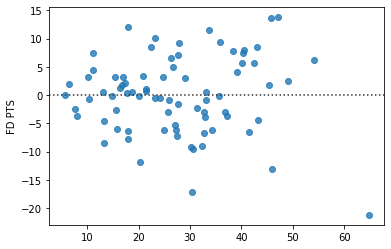

In [292]:
sns.residplot(pred, y_test);

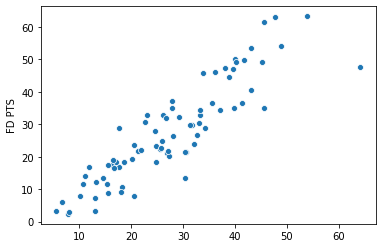

In [172]:
sns.scatterplot(pred,y_test)

In [87]:
years = player_found_dataset.groupby('AGE').apply(np.mean)
years.head()

,PLAYER_ID,TEAM_ID,PLAYER_GAME_ID,Salary,BMI,MIN,PTS,FGM,FGA,FG_PCT,...,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,FD PTS,BMI
AGE,,,,,,,,,,,,,,,,,,,,,
19.0,1.628224e+06,1.610613e+09,31.087879,4139.393939,22.616931,26.427273,9.690909,3.621212,9.030303,0.393545,...,99.845455,0.497509,0.147445,0.540033,19.0,7.406061,80.524242,208.815152,18.941818,22.616931
20.0,1.628353e+06,1.610613e+09,36.461918,5178.465753,23.563782,27.028493,12.095342,4.527671,10.100274,0.446004,...,100.351781,0.495642,0.146180,0.551167,20.0,11.310137,79.298082,211.164384,24.014356,23.563782
21.0,1.516608e+06,1.610613e+09,49.196078,5255.673417,23.868592,26.557056,11.951141,4.544519,9.747027,0.466344,...,99.947927,0.501305,0.144508,0.553556,21.0,14.606557,80.094503,218.121826,24.276406,23.868592
22.0,1.348230e+06,1.610613e+09,58.734659,5343.906655,24.205503,27.041775,12.695477,4.745895,10.229329,0.462277,...,99.361855,0.499741,0.145270,0.554827,22.0,19.636416,79.449726,217.735811,24.703140,24.205503
23.0,1.080843e+06,1.610613e+09,65.322181,5198.166819,24.519611,26.372365,11.833639,4.500229,9.575160,0.467442,...,99.250229,0.498820,0.144347,0.550816,23.0,21.189505,79.597388,221.469982,24.307470,24.519611


In [88]:
m_default_graph = m_default

We wanted to see if a player's age had an effect on how well they perform and how many FanDuel points they earn. We plotted this information below to visualize the trend. It's noticed that players between the ages of 25 and 30 earn the most points on average.

Text(0, 0.5, 'FD Points')

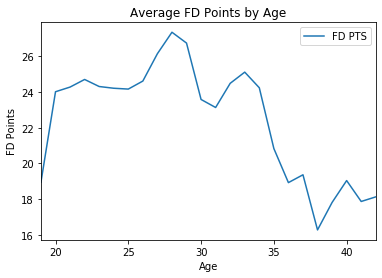

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt

agemean = years.plot('AGE','FD PTS')

agemean.set_title('Average FD Points by Age')

agemean.set_xlabel('Age')

agemean.set_ylabel('FD Points')

Salaries are an important factor when drafting players in FanDuel. We wanted to explore if age had any effect to the draft cost of a player. We plotted this information below and learned that the most expensive players are also between 25-30 years old. It could very well be this is because this same age range earns the most points. 

Text(0, 0.5, 'Salary')

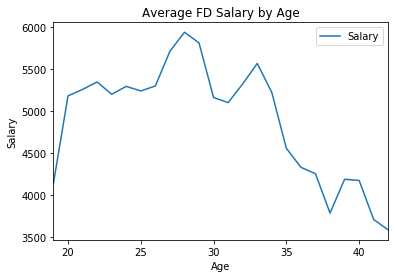

In [90]:
agemean = years.plot('AGE','Salary')

agemean.set_title('Average FD Salary by Age')

agemean.set_xlabel('Age')

agemean.set_ylabel('Salary')

In [91]:
DraftPick = player_found_dataset.groupby('DRAFT_NUMBER').apply(np.mean)
DraftPick

,PLAYER_ID,TEAM_ID,PLAYER_GAME_ID,Salary,BMI,MIN,PTS,FGM,FGA,FG_PCT,...,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,FD PTS,BMI
DRAFT_NUMBER,,,,,,,,,,,,,,,,,,,,,
1,5.164603e+05,1.610613e+09,91.933102,8851.585728,25.050929,33.934093,21.367691,8.033697,16.068385,0.504848,...,99.737364,0.500054,0.140418,0.561889,26.197225,1.0,80.391972,230.916254,40.801090,25.050929
2,5.269648e+05,1.610613e+09,88.433685,6249.242772,24.758420,29.357503,14.773749,5.618173,11.809087,0.475578,...,99.858651,0.501673,0.139846,0.558005,26.842129,2.0,80.180817,226.637907,28.759293,24.758420
3,4.839132e+05,1.610613e+09,91.150608,7167.795139,25.090214,30.251302,17.589410,6.349826,13.293403,0.484848,...,99.068142,0.501393,0.143108,0.562354,26.697049,3.0,80.384115,230.995660,33.204253,25.090214
4,3.611854e+05,1.610613e+09,79.874297,6534.798160,23.777014,28.719469,14.568217,5.312724,11.853347,0.454704,...,98.910577,0.497959,0.141574,0.555725,26.754216,4.0,78.826776,210.314768,29.791926,23.777014
5,4.635980e+05,1.610613e+09,80.463530,5558.581355,24.856791,26.063444,12.785067,4.582650,10.209322,0.443775,...,99.151489,0.498230,0.143255,0.555228,28.533017,5.0,78.736729,220.152784,26.006603,24.856791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,6.339286e+04,1.610613e+09,81.416129,4588.064516,24.185302,24.554839,8.967742,3.570968,7.119355,0.494071,...,97.980645,0.506645,0.142600,0.562274,35.922581,57.0,81.096774,226.677419,21.271613,24.185302
58,1.025405e+06,1.610613e+09,12.807692,3576.923077,24.122961,20.980769,8.423077,3.096154,7.307692,0.427519,...,100.423077,0.506731,0.135615,0.549846,25.596154,58.0,77.576923,206.788462,15.507692,24.122961
59,1.628417e+06,1.610613e+09,8.000000,3588.235294,24.165625,22.352941,5.823529,2.352941,5.294118,0.439118,...,95.352941,0.482588,0.134235,0.527176,25.000000,59.0,80.000000,220.000000,14.041176,24.165625


Next we wanted to visualize if higher drafted players cost more. From our data, it tends to be the case that the number 1 pick is more expensive, however there doesn't seem to be a significant relationship between draft pick positions and salaries. 

In [92]:
DraftPick['DRAFT_NUMBER'] = DraftPick['DRAFT_NUMBER'].astype(int)

Text(0, 0.5, 'Salary')

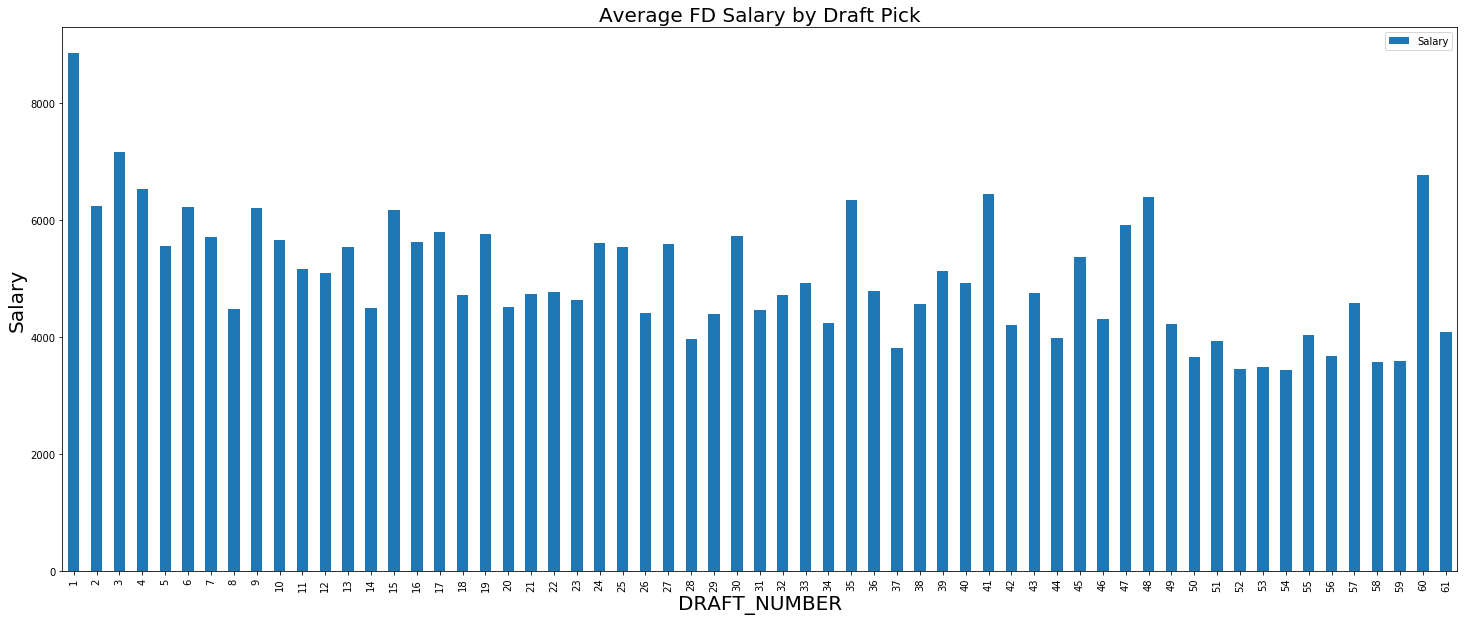

In [93]:
DraftMean = DraftPick.plot.bar('DRAFT_NUMBER','Salary', figsize = (25,10))
DraftMean.set_title('Average FD Salary by Draft Pick', fontsize = 20)
DraftMean.set_xlabel('DRAFT_NUMBER', fontsize = 20)
DraftMean.set_ylabel('Salary', fontsize = 20)

Another area we chose to explore was the impact a player's height has on the FanDuel points earned. Because different positions suite different heights of players, there doesn't seem to be a clear trend between height and points earned. 

Text(26.200000000000017, 0.5, 'Points')

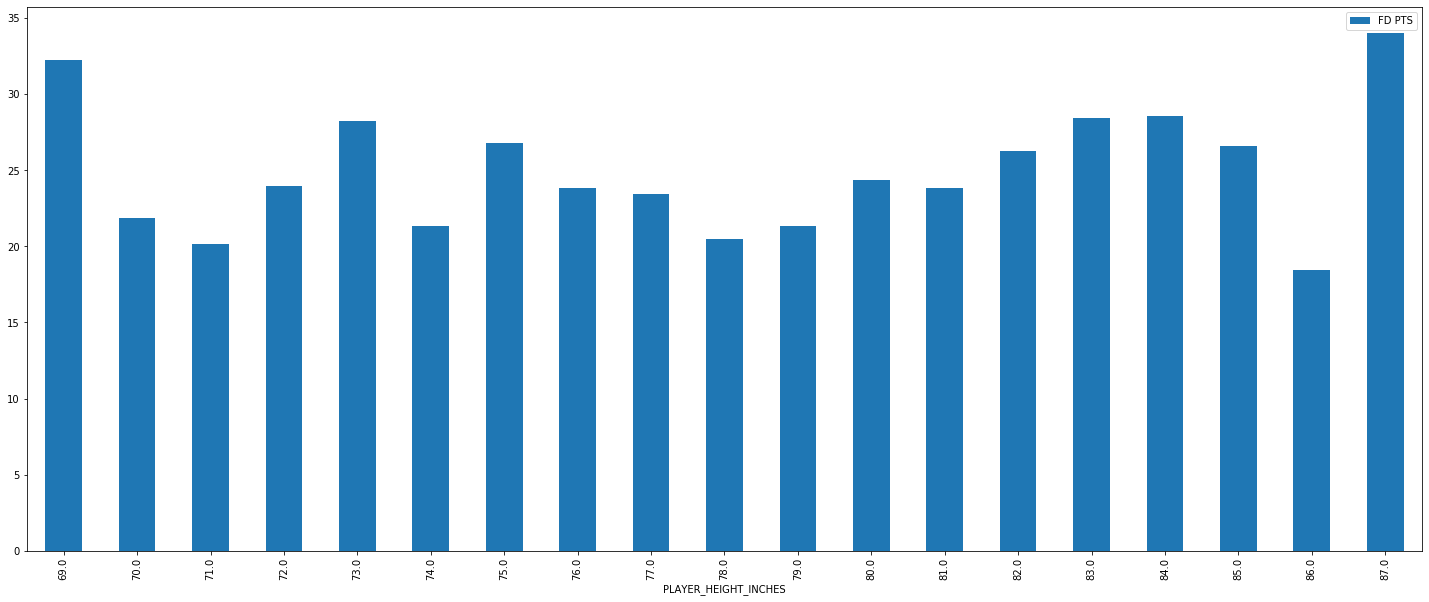

In [94]:
Height = player_found_dataset.groupby('PLAYER_HEIGHT_INCHES').apply(np.mean)
HeightGraph = Height.plot.bar('PLAYER_HEIGHT_INCHES','FD PTS', figsize = (25,10))
DraftMean.set_title('Average Points by Height', fontsize = 20)
DraftMean.set_xlabel('Height', fontsize = 20)
DraftMean.set_ylabel('Points', fontsize = 20)


Next, we wanted to see whether expensive players are actually worth their salary. By viewing the relationship between points scored in the last 10 games and corresponding salary, we see that there is a clear relationship between the two variables. This indicates that more expensive players tend to earn the most FanDuel points. 

In [95]:
SalaryMean = m_default.groupby('Salary').apply(np.mean)


In [96]:
m_default.groupby('FD PTS_LAST_10').apply(np.mean)

,PLAYER_ID,TEAM_ID,Salary,MIN,AGE,DRAFT_NUMBER,BMI,BMI,Home?,PTS_LAST_5,...,BLK_LAST_5,TOV_LAST_5,FD PTS_LAST_5,FD PTS_LAST_10,PTS_LAST_10,Position_C,Position_PF,Position_PG,Position_SF,Position_SG
FD PTS_LAST_10,,,,,,,,,,,,,,,,,,,,,
-2.80,2.564000e+03,1.610613e+09,3500.0,19.0,35.000000,21.0,27.460938,27.460938,0.0,0.000000,...,0.0,4.000000,-2.80,-2.80,0.000000,0.0,1.000000,0.0,0.000000,0.000000
-1.00,1.629019e+06,1.610613e+09,3600.0,16.0,23.000000,61.0,23.713948,23.713948,1.0,6.600000,...,0.0,1.800000,10.50,-1.00,2.000000,0.0,0.000000,0.0,0.000000,1.000000
0.00,6.777747e+05,1.610613e+09,3500.0,16.0,27.333333,61.0,24.989340,24.989340,1.0,0.666667,...,0.0,0.666667,0.00,0.00,0.666667,0.0,0.333333,0.0,0.333333,0.333333
0.20,1.628975e+06,1.610613e+09,3500.0,26.0,23.000000,32.0,25.162162,25.162162,1.0,4.400000,...,0.4,1.000000,11.38,0.20,0.000000,1.0,0.000000,0.0,0.000000,0.000000
0.20,1.627789e+06,1.610613e+09,3500.0,15.0,22.000000,24.0,23.687541,23.687541,0.0,0.000000,...,0.0,1.000000,0.20,0.20,0.000000,0.0,0.000000,0.0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71.92,2.019350e+05,1.610613e+09,13900.0,39.0,29.000000,3.0,26.085343,26.085343,1.0,42.000000,...,1.4,5.000000,66.40,71.92,45.400000,0.0,0.000000,0.0,0.000000,1.000000
72.90,2.019350e+05,1.610613e+09,11200.0,38.0,27.000000,3.0,26.085343,26.085343,0.0,41.000000,...,0.0,1.000000,72.90,72.90,41.000000,0.0,0.000000,0.0,0.000000,1.000000
76.90,2.030760e+05,1.610613e+09,10800.0,40.0,24.000000,1.0,25.817826,25.817826,1.0,45.000000,...,2.0,1.000000,76.90,76.90,45.000000,0.0,1.000000,0.0,0.000000,0.000000


We wanted to look at how accurate our model is on a given day, in this plot we randomly chose December 12, 2018. 
The X axis is their average FanDuel points in their last 5 games, and the Y axis is their FanDuel point performance
that night. It can be seen that the data is fairly correlated.

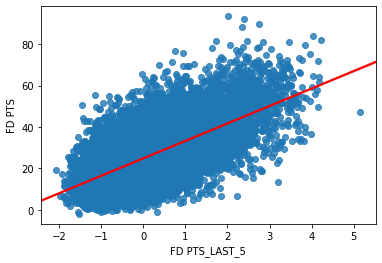

In [777]:


bool_arr = master_dataset['Date'] == '2018-12-14'

AvgLast5 = sns.regplot(X_test['FD PTS_LAST_5'], y_test)
regline = AvgLast5.get_lines()[0]
regline.set_color('red')

The boxplot below depicts our predicted FanDuel points versus actual FanDuel points earned. Overall, our predictions cover a lower range of points scored between the first and third quartile, with a higher predicted median. This could be due to the highly volatile nature of the NBA and professional sports. With many variables such injuries, personal reasons to missing games, break out (large scoring games), and career high games, it can be very challenging to make a fully accurate prediciton regarding player performance.  

In [98]:
Box = pd.DataFrame({'Predicted':pred,'Actual':y_test})

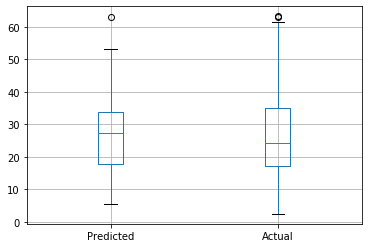

In [99]:
boxplot =Box.boxplot(column=['Predicted','Actual'])

### Conclusion
	
    Looking at the data that we received from our testing, we are able to be fairly accurately predict on how well a player will perform on a given night if we look at the actual performance of the player. The accuracy is a bit below actual performance on a given night, but we believe that to be fine as sports results may not be 100% predicted as many variables may change how the game will end. For example, a player may get injured during the game and our prediction would be off. Overall, a player that has previously played well will continue to play at a high level unless circumstances prevent it.

